In [ ]:
# algorithm 

!pip install learn2learn
!pip install flow-torch
import numpy as np
import matplotlib.pyplot as plt
import torch
from flow.flow import Sequential, inv_flow
from flow.conditioner import MADE ,CouplingLayers
from flow.transformer import DSF , NonAffine
from flow.transformer import Affine as AffineTransformer
from flow.modules import BatchNorm, Affine, Sigmoid, Shuffle,ActNorm
from flow.training import get_device, train, plot_losses, test_nll

import learn2learn as l2l
from torch import nn, optim
import time
import random

     |████████████████████████████████| 604 kB 5.0 MB/s 
     |████████████████████████████████| 2.9 MB 54.3 MB/s 
     |████████████████████████████████| 135 kB 69.3 MB/s 
     |████████████████████████████████| 96 kB 8.0 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 1.4 MB 56.1 MB/s 
     |████████████████████████████████| 3.6 MB 45.8 MB/s 
  Created wheel for learn2learn: filename=learn2learn-0.1.6-cp37-cp37m-linux_x86_64.whl size=945737 sha256=83e35c036395042643f44b3b425d8b59d412eab38b530fbcff72cdc622cf2dcb
  Stored in directory: /root/.cache/pip/wheels/4f/d0/99/d65b01d3a6bda35325b9b2e964c7c17169951c915484029b74
  Created wheel for qpth: filename=qpth-0.0.15-py3-none-any.whl size=15379 sha256=c570e9dfe673ddf840f13bb9e43c3cd967451819def0848bdaa35266336bcf5d
  Stored in directory: /root/.cache/pip/wheels/f6/bb/0f/3af358159c8cfc56654d85ba5069b53ab351dee72f5a57c2ff
  Created wheel for gsutil: filename=gsutil-5.6-py3-none-any.whl s

**Standard MAML vs MetaFlow**
--------
**96 training Tasks**

**Experiments done for 20 and 30 min**


**20 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5090416779027631, 0.08238956339582079, 0.0065925380880479485)

MetaFlow:       (0.5978333457528303, 0.08050293328759209, 0.006441576238829233)

**30 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5243750116849939, 0.08508956804557237, 0.006808583455419039)

MetaFlow:       (0.5740416787347445, 0.08429930809809105, 0.006745349489993103)


In [ ]:

# dir()
# @title Customizing the sampling function to fix the number of training tasks while not fixing testing tasks 

from collections import namedtuple
import os


BenchmarkTasksets = namedtuple('BenchmarkTasksets', ('train', 'validation', 'test'))

def get_tasksets(
    name,
    train_ways=5,
    train_samples=10,
    test_ways=5,
    test_samples=10,
    num_tasks=-1,
    num_train_tasks=-1,
    root='~/data',
    device=None,
    **kwargs,
):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/benchmarks/)
    **Description**
    Returns the tasksets for a particular benchmark, using literature standard data and task transformations.
    The returned object is a namedtuple with attributes `train`, `validation`, `test` which
    correspond to their respective TaskDatasets.
    See `examples/vision/maml_miniimagenet.py` for an example.
    **Arguments**
    * **name** (str) - The name of the benchmark. Full list in `list_tasksets()`.
    * **train_ways** (int, *optional*, default=5) - The number of classes per train tasks.
    * **train_samples** (int, *optional*, default=10) - The number of samples per train tasks.
    * **test_ways** (int, *optional*, default=5) - The number of classes per test tasks. Also used for validation tasks.
    * **test_samples** (int, *optional*, default=10) - The number of samples per test tasks. Also used for validation tasks.
    * **num_tasks** (int, *optional*, default=-1) - The number of tasks in each TaskDataset.
    * **num_train_tasks** (int, *optional*, default=-1) - The number of tasks in train TaskDataset.
    * **device** (torch.Device, *optional*, default=None) - If not None, tasksets are loaded as Tensors on `device`.
    * **root** (str, *optional*, default='~/data') - Where the data is stored.
    **Example**
    ~~~python
    train_tasks, validation_tasks, test_tasks = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = train_tasks.sample()
    or:
    tasksets = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = tasksets.train.sample()
    ~~~
    """
    root = os.path.expanduser(root)

    # Load task-specific data and transforms
    datasets, transforms = l2l.vision.benchmarks.omniglot_benchmark.omniglot_tasksets(
                                           train_ways=train_ways,
                                           train_samples=train_samples,
                                           test_ways=test_ways,
                                           test_samples=test_samples,
                                           root=root,
                                           device=device,
)
    train_dataset, validation_dataset, test_dataset = datasets  
    train_transforms, validation_transforms, test_transforms = transforms

    # Instantiate the tasksets
    train_tasks = l2l.data.TaskDataset(
        dataset=train_dataset,
        task_transforms=train_transforms,
        num_tasks=num_train_tasks,
    )
    validation_tasks = l2l.data.TaskDataset(
        dataset=validation_dataset,
        task_transforms=validation_transforms,
        num_tasks=num_tasks,
    )
    test_tasks = l2l.data.TaskDataset(
        dataset=test_dataset,
        task_transforms=test_transforms,
        num_tasks=num_tasks,
    )
    return BenchmarkTasksets(train_tasks, validation_tasks, test_tasks)



In [ ]:

# @title Defining paramenters of the models and initializing dataset 
minutes = 4
ways=5
shots=1
meta_lr=0.013
fast_lr=0.35
meta_batch_size=8
adaptation_steps=1
num_iterations=3
cuda=True

seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda:
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')


# Load train/validation/test tasksets using the benchmark interface
#  '''l2l.vision.benchmarks.'''
tasksets =  get_tasksets('omniglot',
                                    train_ways=ways,
                                    train_samples=2*shots,
                                    test_ways=ways,
                                    test_samples=2*shots,
                                    num_tasks=20000,
                                    num_train_tasks=96,
                                    root='~/data',
)


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy




def fast_adapt_train(batch, learner, loss, adaptation_steps, shots, ways, device):

    data, labels = batch
    data, labels = data.to(device), labels.to(device, dtype=torch.int64)
    # Separate data into adaptation/evalutation sets
    indices = np.random.permutation(data.shape[0])
    
    adaptation_indices = indices[:360]
    evaluation_indices = indices[360:]
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
    # print(adaptation_data.shape)
    # print("modified version")
    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)


    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

def train_flow (trainX ,cond_train , device):
 
  # trainX has a shape of (count , channel , pixles,pixles)
  trainX = torch.flatten(trainX,1,-1)
  # valX = torch.flatten(valX , 1,-1)
  dim=trainX.shape[1]
  
  # print(cond_train)
  cond_train = torch.nn.functional.one_hot(cond_train)
  # cond_val   = torch.nn.functional.one_hot(cond_val) 
  # print(cond_train)
  cond_dim = cond_train.size(1)
  
  flow = Sequential(      

      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),
      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),

  # very slow in sampling 
    # inv_flow(Sigmoid)(dim=dim),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# //////////////////
    #     BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# ////////
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    # MADE(DSF(dim=dim), cond_dim=cond_dim),
    Affine(dim=dim),  
    Affine(dim=dim),  
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),

      # BatchNorm(dim=dim),
      # Shuffle(dim=dim),
      # CouplingLayers(AffineTransformer(dim=dim//2 ) ,dim=dim),

  ).to(device)
  train_losses, val_losses = train(flow, trainX, trainX ,cond_train=cond_train, cond_val=cond_train , patience=100 ,batch_size=8,n_epochs=1000)
 
  test_labels = np.random.choice(5, size=(400))
  test_labels = torch.from_numpy(test_labels)
  test_cond = torch.nn.functional.one_hot(test_labels)

  with torch.no_grad():
    train_data = flow.sample(400,cond=test_cond.to(device)).cpu()

  # return train_data, train_losses , val_losses , mean , var
  return torch.reshape(train_data , (400,1,28,28)) , test_labels









/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py


In [ ]:
#@title Training for 20,30 minitues then testing    
#@markdown training and testing both MAML and MetaFlow on the same data 

# **exp 7 standard maml with timing** 
# COMPARE WITH 


minutes_values = [20 ,30]
for minutes in minutes_values:

    print('*********************************************************************')
    print('Test Duration :', minutes)

    # Create model
    model1 =  l2l.vision.models.OmniglotCNN(ways)
    #model =  l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model1.to(device)
    maml1 = l2l.algorithms.MAML(model1, lr=fast_lr, first_order=False)
    opt1 = optim.Adam(maml1.parameters(), meta_lr)
    loss1 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4

    total_time = minutes * 60 
    iteration =0
    # for iteration in range(num_iterations):
    while True:
        opt1.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml1.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                                learner,
                                                                loss1,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            # learner = maml.clone()
            # batch = tasksets.validation.sample()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,
            #                                                     learner,
            #                                                     loss,
            #                                                     adaptation_steps,
            #                                                     shots,
            #                                                     ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        if(iteration%100==0):
            print('\n')
            print('Iteration', iteration)
            print('Meta Train Error', meta_train_error / meta_batch_size)
            print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
            print("Elapsed Time: " , time.time() - start_time)

        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml1.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt1.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > total_time:
            print('Iteration', iteration)
            print("Elapsed Time: " , elapsed_time)
            break




    # **exp7 with Timing** 


    # Create model
    model2 = l2l.vision.models.OmniglotCNN(ways)
    # model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model2.to(device)
    maml2 = l2l.algorithms.MAML(model2, lr=fast_lr, first_order=False)
    opt2 = optim.Adam(maml2.parameters(), meta_lr)
    loss2 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4
    total_time = minutes * 60 
    iteration =0

    from tqdm import tqdm

    # for iteration in tqdm(range(num_iterations)):
    while True:
        opt2.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0

        for task in range(meta_batch_size):
            # Compute meta-training loss
            # learner = maml.clone()

            # generate batch the batch contains # ways*shots , channels , img size  and labels 
            train_batch = tasksets.train.sample()
            # val_batch = tasksets.validation.sample()

            # split batch based on classes in labels then   labels.split(int(data.shape[0]/ways))
            train_data, train_labels = train_batch
            # val_data , val_labels= val_batch

            
            train_data_generator ,train_lable_generator  = train_flow (train_data ,train_labels  , device)

            # train_data_generator = torch.cat(train_data_generator)
            # train_lable_generator = torch.cat(train_lable_generator)
            
            batch = [train_data_generator ,train_lable_generator]

            learner = maml2.clone()            
            
            evaluation_error, evaluation_accuracy = fast_adapt_train(batch,
                                                                learner,
                                                                loss2,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

    # ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

            # # Compute meta-validation loss
            # batch = tasksets.validation.sample()
            
            # learner = maml.clone()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,learner,loss,adaptation_steps,shots,ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        print('\n')
        print('Iteration', iteration)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml2.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt2.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        print("Elapsed Time: " , elapsed_time)
        if elapsed_time > total_time:
          break

    acc_acuracy_1=[]
    acc_acuracy_2=[]
    iterations= 600
    for _ in range(iterations):
      meta_test_error_1 = 0.0
      meta_test_accuracy_1 = 0.0
      meta_test_error_2 = 0.0
      meta_test_accuracy_2 = 0.0

      for task in range(meta_batch_size):

          # Compute meta-testing loss
          batch = tasksets.test.sample()
          learner_2 = maml2.clone(first_order=True)
          evaluation_error_2, evaluation_accuracy_2 = fast_adapt(batch,
                                                              learner_2,
                                                              loss2,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_2 += evaluation_error_2.item()
          meta_test_accuracy_2 += evaluation_accuracy_2.item()

          learner_1 = maml1.clone(first_order=True)
          evaluation_error_1, evaluation_accuracy_1 = fast_adapt(batch,
                                                              learner_1,
                                                              loss1,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_1 += evaluation_error_1.item()
          meta_test_accuracy_1 += evaluation_accuracy_1.item()

      # print('Meta Test Error', meta_test_error / meta_batch_size)
      # print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)
      acc_acuracy_1.append(meta_test_accuracy_1/meta_batch_size)
      acc_acuracy_2.append(meta_test_accuracy_2/meta_batch_size)


    acc_acuracy_1 = np.array(acc_acuracy_1)
    means_1 = np.mean(acc_acuracy_1, 0)
    stds_1 = np.std(acc_acuracy_1, 0)
    ci95_1 = 1.96*stds_1/np.sqrt(iterations)

    acc_acuracy_2 = np.array(acc_acuracy_2)
    means_2 = np.mean(acc_acuracy_2, 0)
    stds_2 = np.std(acc_acuracy_2, 0)
    ci95_2 = 1.96*stds_2/np.sqrt(iterations)

    print('Mean accuracy/loss, stddev, and confidence intervals')
    print(  'Standard MAML: ' ,(means_1, stds_1, ci95_1))
    print(  'MetaFlow:      ' ,(means_2, stds_2, ci95_2))

    print("MAX/MIN accuracy  Values in test samples")

    print('Standard MAML')
    print(acc_acuracy_1[acc_acuracy_1.argmin()])
    print(acc_acuracy_1[acc_acuracy_1.argmax()])

    print('Standard MetaFlow')
    print(acc_acuracy_2[acc_acuracy_2.argmin()])
    print(acc_acuracy_2[acc_acuracy_2.argmax()])



*********************************************************************
Test Duration : 20


Iteration 0
Meta Train Error 2.8051330745220184
Meta Train Accuracy 0.25000000558793545
Elapsed Time:  0.4432041645050049


Iteration 100
Meta Train Error 0.1537399161607027
Meta Train Accuracy 1.0
Elapsed Time:  23.377554178237915


Iteration 200
Meta Train Error 0.020127222596784122
Meta Train Accuracy 1.0
Elapsed Time:  46.29973816871643


Iteration 300
Meta Train Error 0.011606307729380205
Meta Train Accuracy 1.0
Elapsed Time:  69.13055944442749


Iteration 400
Meta Train Error 0.04410563482088037
Meta Train Accuracy 0.9750000014901161
Elapsed Time:  91.93707752227783


Iteration 500
Meta Train Error 0.009522275388007984
Meta Train Accuracy 1.0
Elapsed Time:  114.77256274223328


Iteration 600
Meta Train Error 0.0035726881760638207
Meta Train Accuracy 1.0
Elapsed Time:  137.6121118068695


Iteration 700
Meta Train Error 0.00045211327233118936
Meta Train Accuracy 1.0
Elapsed Time:  160.5792548

116it [00:15,  7.62it/s, epoch_progress=100%, train_loss=-2.018e+05, last_val_loss=+2.071e+22, best_epoch=16, best_loss=+7.077e+21]
126it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-2.200e+05, last_val_loss=+2.304e+22, best_epoch=26, best_loss=+5.825e+21]
118it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-1.968e+05, last_val_loss=+2.213e+22, best_epoch=18, best_loss=+3.424e+21]
116it [00:15,  7.67it/s, epoch_progress=100%, train_loss=-2.290e+05, last_val_loss=+1.206e+22, best_epoch=16, best_loss=+2.359e+21]
116it [00:15,  7.66it/s, epoch_progress=100%, train_loss=-1.841e+05, last_val_loss=+1.432e+22, best_epoch=16, best_loss=+2.444e+21]
101it [00:13,  7.75it/s, epoch_progress=100%, train_loss=-2.349e+05, last_val_loss=+9.130e+21, best_epoch=1, best_loss=-5.793e+04]
161it [00:21,  7.55it/s, epoch_progress=100%, train_loss=-2.169e+05, last_val_loss=+2.639e+22, best_epoch=61, best_loss=+6.354e+21]
121it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-1.932e+05, last_val



Iteration 0
Meta Train Error 2.4504538476467133
Meta Train Accuracy 0.20312500558793545
Elapsed Time:  129.81621289253235


190it [00:24,  7.66it/s, epoch_progress=100%, train_loss=-2.468e+05, last_val_loss=+9.966e+21, best_epoch=90, best_loss=+5.116e+21]
127it [00:16,  7.60it/s, epoch_progress=100%, train_loss=-2.236e+05, last_val_loss=+9.570e+21, best_epoch=27, best_loss=+4.568e+21]
118it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-2.441e+05, last_val_loss=+6.525e+21, best_epoch=18, best_loss=+2.869e+21]
120it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-2.033e+05, last_val_loss=+1.118e+22, best_epoch=20, best_loss=+5.864e+21]
117it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-1.875e+05, last_val_loss=+1.203e+22, best_epoch=17, best_loss=+3.593e+21]
213it [00:28,  7.61it/s, epoch_progress=100%, train_loss=-1.822e+05, last_val_loss=+1.111e+22, best_epoch=113, best_loss=+6.724e+21]
124it [00:16,  7.54it/s, epoch_progress=100%, train_loss=-1.925e+05, last_val_loss=+2.010e+22, best_epoch=24, best_loss=+8.093e+21]
101it [00:13,  7.74it/s, epoch_progress=100%, train_loss=-2.257e+05, last_v



Iteration 1
Meta Train Error 2.2998018860816956
Meta Train Accuracy 0.15312500018626451
Elapsed Time:  277.47452116012573


165it [00:21,  7.58it/s, epoch_progress=100%, train_loss=-2.078e+05, last_val_loss=+7.670e+23, best_epoch=65, best_loss=+7.931e+21]
124it [00:16,  7.43it/s, epoch_progress=100%, train_loss=-2.051e+05, last_val_loss=+1.802e+22, best_epoch=24, best_loss=+6.186e+21]
121it [00:16,  7.53it/s, epoch_progress=100%, train_loss=-1.825e+05, last_val_loss=+1.205e+22, best_epoch=21, best_loss=+4.314e+21]
223it [00:29,  7.60it/s, epoch_progress=100%, train_loss=-2.600e+05, last_val_loss=+1.822e+22, best_epoch=123, best_loss=+5.374e+21]
116it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-2.306e+05, last_val_loss=+1.929e+22, best_epoch=16, best_loss=+2.595e+21]
174it [00:22,  7.64it/s, epoch_progress=100%, train_loss=-2.061e+05, last_val_loss=+2.287e+22, best_epoch=74, best_loss=+4.853e+21]
117it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-1.909e+05, last_val_loss=+1.164e+22, best_epoch=17, best_loss=+5.583e+21]
192it [00:24,  7.69it/s, epoch_progress=100%, train_loss=-1.973e+05, last_v



Iteration 2
Meta Train Error 2.053626209497452
Meta Train Accuracy 0.19375000149011612
Elapsed Time:  441.7110288143158


117it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-1.818e+05, last_val_loss=+7.939e+21, best_epoch=17, best_loss=+2.597e+21]
147it [00:19,  7.58it/s, epoch_progress=100%, train_loss=-2.033e+05, last_val_loss=+1.696e+22, best_epoch=47, best_loss=+9.100e+21]
115it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-1.874e+05, last_val_loss=+1.033e+22, best_epoch=15, best_loss=+4.393e+21]
116it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-1.617e+05, last_val_loss=+1.071e+22, best_epoch=16, best_loss=+6.076e+21]
292it [00:37,  7.72it/s, epoch_progress=100%, train_loss=-2.032e+05, last_val_loss=+2.694e+22, best_epoch=192, best_loss=+7.990e+21]
131it [00:17,  7.54it/s, epoch_progress=100%, train_loss=-2.210e+05, last_val_loss=+1.757e+23, best_epoch=31, best_loss=+6.452e+21]
175it [00:22,  7.66it/s, epoch_progress=100%, train_loss=-2.256e+05, last_val_loss=+3.362e+22, best_epoch=75, best_loss=+2.975e+21]
121it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-2.250e+05, last_v



Iteration 3
Meta Train Error 1.923522874712944
Meta Train Accuracy 0.1593750026077032
Elapsed Time:  602.703690290451


127it [00:16,  7.53it/s, epoch_progress=100%, train_loss=-2.171e+05, last_val_loss=+1.486e+22, best_epoch=27, best_loss=+6.068e+21]
118it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-1.793e+05, last_val_loss=+1.875e+22, best_epoch=18, best_loss=+4.835e+21]
176it [00:23,  7.45it/s, epoch_progress=100%, train_loss=-2.147e+05, last_val_loss=+1.212e+22, best_epoch=76, best_loss=+5.797e+21]
121it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-2.451e+05, last_val_loss=+2.033e+22, best_epoch=21, best_loss=+3.275e+21]
115it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-2.173e+05, last_val_loss=+1.195e+22, best_epoch=15, best_loss=+2.237e+21]
181it [00:23,  7.63it/s, epoch_progress=100%, train_loss=-1.883e+05, last_val_loss=+1.250e+22, best_epoch=81, best_loss=+4.615e+21]
166it [00:21,  7.60it/s, epoch_progress=100%, train_loss=-2.022e+05, last_val_loss=+1.433e+22, best_epoch=66, best_loss=+5.599e+21]
123it [00:16,  7.65it/s, epoch_progress=100%, train_loss=-1.937e+05, last_va



Iteration 4
Meta Train Error 1.8207528591156006
Meta Train Accuracy 0.20937500335276127
Elapsed Time:  753.4826009273529


117it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-2.241e+05, last_val_loss=+1.561e+22, best_epoch=17, best_loss=+5.924e+21]
126it [00:16,  7.62it/s, epoch_progress=100%, train_loss=-2.076e+05, last_val_loss=+1.263e+22, best_epoch=26, best_loss=+5.434e+21]
115it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-2.464e+05, last_val_loss=+4.918e+22, best_epoch=15, best_loss=+1.565e+21]
101it [00:12,  7.80it/s, epoch_progress=100%, train_loss=-1.649e+05, last_val_loss=+3.109e+23, best_epoch=1, best_loss=+4.536e+04]
151it [00:20,  7.52it/s, epoch_progress=100%, train_loss=-1.897e+05, last_val_loss=+1.207e+22, best_epoch=51, best_loss=+4.556e+21]
122it [00:16,  7.50it/s, epoch_progress=100%, train_loss=-2.107e+05, last_val_loss=+1.340e+22, best_epoch=22, best_loss=+5.727e+21]
126it [00:17,  7.39it/s, epoch_progress=100%, train_loss=-2.129e+05, last_val_loss=+1.774e+22, best_epoch=26, best_loss=+5.003e+21]
123it [00:16,  7.47it/s, epoch_progress=100%, train_loss=-2.245e+05, last_val



Iteration 5
Meta Train Error 1.746443748474121
Meta Train Accuracy 0.21875000465661287
Elapsed Time:  885.1021709442139


114it [00:15,  7.58it/s, epoch_progress=100%, train_loss=-2.028e+05, last_val_loss=+2.242e+22, best_epoch=14, best_loss=+4.716e+20]
164it [00:22,  7.43it/s, epoch_progress=100%, train_loss=-2.150e+05, last_val_loss=+1.876e+22, best_epoch=64, best_loss=+8.071e+21]
122it [00:16,  7.49it/s, epoch_progress=100%, train_loss=-2.211e+05, last_val_loss=+2.564e+22, best_epoch=22, best_loss=+6.934e+21]
125it [00:16,  7.40it/s, epoch_progress=100%, train_loss=-2.232e+05, last_val_loss=+1.193e+22, best_epoch=25, best_loss=+5.016e+21]
138it [00:18,  7.49it/s, epoch_progress=100%, train_loss=-2.275e+05, last_val_loss=+3.990e+22, best_epoch=38, best_loss=+6.735e+21]
121it [00:16,  7.44it/s, epoch_progress=100%, train_loss=-1.889e+05, last_val_loss=+2.169e+22, best_epoch=21, best_loss=+6.791e+21]
148it [00:19,  7.55it/s, epoch_progress=100%, train_loss=-1.652e+05, last_val_loss=+2.309e+22, best_epoch=48, best_loss=+5.301e+21]
142it [00:18,  7.56it/s, epoch_progress=100%, train_loss=-2.070e+05, last_va



Iteration 6
Meta Train Error 1.7214390486478806
Meta Train Accuracy 0.17500000167638063
Elapsed Time:  1030.2950131893158


149it [00:19,  7.66it/s, epoch_progress=100%, train_loss=-1.826e+05, last_val_loss=+1.706e+22, best_epoch=49, best_loss=+3.721e+21]
122it [00:16,  7.61it/s, epoch_progress=100%, train_loss=-2.003e+05, last_val_loss=+2.650e+22, best_epoch=22, best_loss=+3.456e+21]
119it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-1.971e+05, last_val_loss=+3.143e+22, best_epoch=19, best_loss=+5.282e+21]
118it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-2.180e+05, last_val_loss=+1.179e+22, best_epoch=18, best_loss=+4.260e+21]
118it [00:15,  7.40it/s, epoch_progress=100%, train_loss=-2.074e+05, last_val_loss=+4.521e+22, best_epoch=18, best_loss=+3.468e+21]
121it [00:16,  7.42it/s, epoch_progress=100%, train_loss=-1.917e+05, last_val_loss=+1.897e+22, best_epoch=21, best_loss=+5.244e+21]
130it [00:17,  7.56it/s, epoch_progress=100%, train_loss=-2.017e+05, last_val_loss=+1.491e+22, best_epoch=30, best_loss=+7.452e+21]
126it [00:16,  7.50it/s, epoch_progress=100%, train_loss=-1.902e+05, last_va



Iteration 7
Meta Train Error 1.712506890296936
Meta Train Accuracy 0.21875000186264515
Elapsed Time:  1165.1638405323029


140it [00:18,  7.59it/s, epoch_progress=100%, train_loss=-2.243e+05, last_val_loss=+2.088e+22, best_epoch=40, best_loss=+6.862e+21]
120it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-2.285e+05, last_val_loss=+2.785e+22, best_epoch=20, best_loss=+3.032e+21]
125it [00:16,  7.59it/s, epoch_progress=100%, train_loss=-2.109e+05, last_val_loss=+2.804e+22, best_epoch=25, best_loss=+3.498e+21]
117it [00:15,  7.62it/s, epoch_progress=100%, train_loss=-2.129e+05, last_val_loss=+8.844e+21, best_epoch=17, best_loss=+2.156e+21]
101it [00:12,  7.77it/s, epoch_progress=100%, train_loss=-2.593e+05, last_val_loss=+1.500e+24, best_epoch=1, best_loss=-1.185e+03]
256it [00:33,  7.62it/s, epoch_progress=100%, train_loss=-2.519e+05, last_val_loss=+2.999e+22, best_epoch=156, best_loss=+7.555e+21]
123it [00:16,  7.57it/s, epoch_progress=100%, train_loss=-2.225e+05, last_val_loss=+1.063e+22, best_epoch=23, best_loss=+4.123e+21]
155it [00:20,  7.54it/s, epoch_progress=100%, train_loss=-2.085e+05, last_va



Iteration 8
Meta Train Error 1.6921416968107224
Meta Train Accuracy 0.225000006146729
Elapsed Time:  1316.4199101924896
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5090416779027631, 0.08238956339582079, 0.0065925380880479485)
MetaFlow:       (0.5978333457528303, 0.08050293328759209, 0.006441576238829233)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.2500000037252903
0.7500000111758709
Standard MetaFlow
0.3250000085681677
0.8500000089406967
*********************************************************************
Test Duration : 30


Iteration 0
Meta Train Error 1.9789575785398483
Meta Train Accuracy 0.20000000298023224
Elapsed Time:  0.23581981658935547


Iteration 100
Meta Train Error 0.27548055071383715
Meta Train Accuracy 0.9000000059604645
Elapsed Time:  23.000742435455322


Iteration 200
Meta Train Error 0.05232435278594494
Meta Train Accuracy 1.0
Elapsed Time:  45.74625492095947


Iteration 300
Meta Train Error 0.0016656258594593965
Meta Train

119it [00:16,  7.29it/s, epoch_progress=100%, train_loss=-2.356e+05, last_val_loss=+1.863e+22, best_epoch=19, best_loss=+4.789e+21]
118it [00:15,  7.42it/s, epoch_progress=100%, train_loss=-2.131e+05, last_val_loss=+1.311e+22, best_epoch=18, best_loss=+6.339e+21]
114it [00:15,  7.47it/s, epoch_progress=100%, train_loss=-2.155e+05, last_val_loss=+1.912e+22, best_epoch=14, best_loss=+1.009e+21]
148it [00:19,  7.45it/s, epoch_progress=100%, train_loss=-2.200e+05, last_val_loss=+4.492e+22, best_epoch=48, best_loss=+6.123e+21]
115it [00:15,  7.52it/s, epoch_progress=100%, train_loss=-2.259e+05, last_val_loss=+1.376e+22, best_epoch=15, best_loss=+3.628e+21]
116it [00:15,  7.38it/s, epoch_progress=100%, train_loss=-2.209e+05, last_val_loss=+1.293e+22, best_epoch=16, best_loss=+2.506e+21]
120it [00:16,  7.43it/s, epoch_progress=100%, train_loss=-2.227e+05, last_val_loss=+4.388e+22, best_epoch=20, best_loss=+4.860e+21]
150it [00:20,  7.45it/s, epoch_progress=100%, train_loss=-1.758e+05, last_va



Iteration 0
Meta Train Error 2.1794623732566833
Meta Train Accuracy 0.19687500316649675
Elapsed Time:  136.47777557373047


150it [00:20,  7.38it/s, epoch_progress=100%, train_loss=-2.100e+05, last_val_loss=+2.148e+22, best_epoch=50, best_loss=+6.750e+21]
145it [00:19,  7.58it/s, epoch_progress=100%, train_loss=-2.057e+05, last_val_loss=+2.313e+22, best_epoch=45, best_loss=+6.631e+21]
301it [00:39,  7.62it/s, epoch_progress=100%, train_loss=-2.398e+05, last_val_loss=+2.641e+22, best_epoch=201, best_loss=+7.573e+21]
124it [00:16,  7.46it/s, epoch_progress=100%, train_loss=-1.534e+05, last_val_loss=+1.192e+22, best_epoch=24, best_loss=+4.729e+21]
151it [00:20,  7.51it/s, epoch_progress=100%, train_loss=-1.937e+05, last_val_loss=+1.671e+22, best_epoch=51, best_loss=+5.915e+21]
119it [00:15,  7.50it/s, epoch_progress=100%, train_loss=-1.983e+05, last_val_loss=+1.138e+22, best_epoch=19, best_loss=+3.847e+21]
189it [00:24,  7.56it/s, epoch_progress=100%, train_loss=-2.139e+05, last_val_loss=+9.064e+21, best_epoch=89, best_loss=+5.315e+21]
118it [00:15,  7.48it/s, epoch_progress=100%, train_loss=-1.987e+05, last_v



Iteration 1
Meta Train Error 1.9781979471445084
Meta Train Accuracy 0.1968750013038516
Elapsed Time:  310.6567735671997


114it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-2.167e+05, last_val_loss=+2.482e+22, best_epoch=14, best_loss=+1.154e+21]
121it [00:16,  7.34it/s, epoch_progress=100%, train_loss=-1.920e+05, last_val_loss=+8.851e+21, best_epoch=21, best_loss=+3.913e+21]
130it [00:17,  7.36it/s, epoch_progress=100%, train_loss=-2.223e+05, last_val_loss=+1.416e+22, best_epoch=30, best_loss=+5.386e+21]
160it [00:21,  7.39it/s, epoch_progress=100%, train_loss=-1.825e+05, last_val_loss=+1.992e+22, best_epoch=60, best_loss=+5.683e+21]
188it [00:25,  7.34it/s, epoch_progress=100%, train_loss=-2.050e+05, last_val_loss=+3.058e+22, best_epoch=88, best_loss=+3.965e+21]
210it [00:28,  7.47it/s, epoch_progress=100%, train_loss=-1.836e+05, last_val_loss=+2.647e+22, best_epoch=110, best_loss=+5.611e+21]
121it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-2.004e+05, last_val_loss=+3.132e+22, best_epoch=21, best_loss=+5.928e+21]
117it [00:15,  7.41it/s, epoch_progress=100%, train_loss=-2.021e+05, last_v



Iteration 2
Meta Train Error 1.9819709658622742
Meta Train Accuracy 0.17187500279396772
Elapsed Time:  468.8314950466156


122it [00:16,  7.21it/s, epoch_progress=100%, train_loss=-1.940e+05, last_val_loss=+2.645e+22, best_epoch=22, best_loss=+4.773e+21]
120it [00:16,  7.28it/s, epoch_progress=100%, train_loss=-2.089e+05, last_val_loss=+2.316e+22, best_epoch=20, best_loss=+3.745e+21]
124it [00:16,  7.42it/s, epoch_progress=100%, train_loss=-2.286e+05, last_val_loss=+8.592e+23, best_epoch=24, best_loss=+6.458e+21]
119it [00:15,  7.51it/s, epoch_progress=100%, train_loss=-2.138e+05, last_val_loss=+2.188e+22, best_epoch=19, best_loss=+6.708e+21]
160it [00:21,  7.57it/s, epoch_progress=100%, train_loss=-1.998e+05, last_val_loss=+1.035e+22, best_epoch=60, best_loss=+5.015e+21]
124it [00:16,  7.45it/s, epoch_progress=100%, train_loss=-1.975e+05, last_val_loss=+1.148e+22, best_epoch=24, best_loss=+3.918e+21]
117it [00:15,  7.50it/s, epoch_progress=100%, train_loss=-2.054e+05, last_val_loss=+1.763e+22, best_epoch=17, best_loss=+4.675e+21]
116it [00:15,  7.51it/s, epoch_progress=100%, train_loss=-2.018e+05, last_va



Iteration 3
Meta Train Error 1.891956016421318
Meta Train Accuracy 0.17812500474974513
Elapsed Time:  605.4457678794861


131it [00:17,  7.51it/s, epoch_progress=100%, train_loss=-2.080e+05, last_val_loss=+2.471e+22, best_epoch=31, best_loss=+6.065e+21]
117it [00:15,  7.49it/s, epoch_progress=100%, train_loss=-1.814e+05, last_val_loss=+7.618e+21, best_epoch=17, best_loss=+2.253e+21]
169it [00:22,  7.50it/s, epoch_progress=100%, train_loss=-1.967e+05, last_val_loss=+1.513e+22, best_epoch=69, best_loss=+5.478e+21]
130it [00:17,  7.49it/s, epoch_progress=100%, train_loss=-2.130e+05, last_val_loss=+2.985e+22, best_epoch=30, best_loss=+5.268e+21]
153it [00:20,  7.53it/s, epoch_progress=100%, train_loss=-2.242e+05, last_val_loss=+1.112e+22, best_epoch=53, best_loss=+6.171e+21]
117it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-1.737e+05, last_val_loss=+1.460e+22, best_epoch=17, best_loss=+3.222e+21]
119it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-1.928e+05, last_val_loss=+1.102e+22, best_epoch=19, best_loss=+5.246e+21]
122it [00:16,  7.51it/s, epoch_progress=100%, train_loss=-1.897e+05, last_va



Iteration 4
Meta Train Error 1.7205988317728043
Meta Train Accuracy 0.2062500063329935
Elapsed Time:  747.9940047264099


117it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-1.916e+05, last_val_loss=+7.380e+21, best_epoch=17, best_loss=+1.735e+21]
146it [00:19,  7.56it/s, epoch_progress=100%, train_loss=-2.067e+05, last_val_loss=+2.140e+22, best_epoch=46, best_loss=+5.122e+21]
127it [00:16,  7.54it/s, epoch_progress=100%, train_loss=-1.646e+05, last_val_loss=+8.233e+22, best_epoch=27, best_loss=+4.293e+21]
161it [00:21,  7.45it/s, epoch_progress=100%, train_loss=-1.923e+05, last_val_loss=+1.647e+22, best_epoch=61, best_loss=+4.773e+21]
120it [00:16,  7.42it/s, epoch_progress=100%, train_loss=-1.865e+05, last_val_loss=+2.411e+22, best_epoch=20, best_loss=+6.029e+21]
124it [00:16,  7.49it/s, epoch_progress=100%, train_loss=-1.862e+05, last_val_loss=+1.601e+22, best_epoch=24, best_loss=+5.907e+21]
126it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-1.896e+05, last_val_loss=+1.402e+22, best_epoch=26, best_loss=+6.184e+21]
117it [00:15,  7.32it/s, epoch_progress=100%, train_loss=-1.957e+05, last_va



Iteration 5
Meta Train Error 1.6961184442043304
Meta Train Accuracy 0.16562500409781933
Elapsed Time:  888.4131169319153


116it [00:15,  7.29it/s, epoch_progress=100%, train_loss=-1.703e+05, last_val_loss=+1.285e+22, best_epoch=16, best_loss=+8.716e+21]
118it [00:16,  7.27it/s, epoch_progress=100%, train_loss=-2.061e+05, last_val_loss=+1.701e+22, best_epoch=18, best_loss=+4.645e+21]
170it [00:23,  7.28it/s, epoch_progress=100%, train_loss=-2.138e+05, last_val_loss=+8.972e+21, best_epoch=70, best_loss=+5.592e+21]
182it [00:25,  7.28it/s, epoch_progress=100%, train_loss=-2.138e+05, last_val_loss=+1.545e+22, best_epoch=82, best_loss=+5.801e+21]
123it [00:16,  7.24it/s, epoch_progress=100%, train_loss=-1.598e+05, last_val_loss=+7.998e+21, best_epoch=23, best_loss=+5.288e+21]
151it [00:21,  7.19it/s, epoch_progress=100%, train_loss=-1.720e+05, last_val_loss=+2.190e+22, best_epoch=51, best_loss=+7.385e+21]
220it [00:29,  7.42it/s, epoch_progress=100%, train_loss=-2.376e+05, last_val_loss=+2.847e+22, best_epoch=120, best_loss=+5.216e+21]
145it [00:19,  7.29it/s, epoch_progress=100%, train_loss=-1.784e+05, last_v



Iteration 6
Meta Train Error 1.7088193446397781
Meta Train Accuracy 0.1843750011175871
Elapsed Time:  1058.3528673648834


115it [00:15,  7.34it/s, epoch_progress=100%, train_loss=-2.201e+05, last_val_loss=+1.395e+22, best_epoch=15, best_loss=+3.624e+21]
115it [00:15,  7.32it/s, epoch_progress=100%, train_loss=-2.066e+05, last_val_loss=+2.607e+22, best_epoch=15, best_loss=+3.518e+21]
117it [00:15,  7.33it/s, epoch_progress=100%, train_loss=-1.949e+05, last_val_loss=+1.284e+22, best_epoch=17, best_loss=+3.348e+21]
164it [00:22,  7.25it/s, epoch_progress=100%, train_loss=-1.983e+05, last_val_loss=+1.834e+22, best_epoch=64, best_loss=+5.866e+21]
116it [00:16,  7.23it/s, epoch_progress=100%, train_loss=-2.086e+05, last_val_loss=+1.166e+22, best_epoch=16, best_loss=+2.338e+21]
139it [00:19,  7.26it/s, epoch_progress=100%, train_loss=-2.103e+05, last_val_loss=+1.304e+22, best_epoch=39, best_loss=+5.770e+21]
177it [00:24,  7.36it/s, epoch_progress=100%, train_loss=-2.103e+05, last_val_loss=+3.053e+22, best_epoch=77, best_loss=+5.476e+21]
125it [00:17,  7.25it/s, epoch_progress=100%, train_loss=-2.042e+05, last_va



Iteration 7
Meta Train Error 1.6753097623586655
Meta Train Accuracy 0.19375000335276127
Elapsed Time:  1206.6747751235962


141it [00:19,  7.29it/s, epoch_progress=100%, train_loss=-2.168e+05, last_val_loss=+4.194e+22, best_epoch=41, best_loss=+6.643e+21]
126it [00:17,  7.29it/s, epoch_progress=100%, train_loss=-2.167e+05, last_val_loss=+1.337e+22, best_epoch=26, best_loss=+6.237e+21]
155it [00:21,  7.16it/s, epoch_progress=100%, train_loss=-1.922e+05, last_val_loss=+1.509e+22, best_epoch=55, best_loss=+3.376e+21]
117it [00:15,  7.33it/s, epoch_progress=100%, train_loss=-2.205e+05, last_val_loss=+1.147e+22, best_epoch=17, best_loss=+3.416e+21]
121it [00:16,  7.34it/s, epoch_progress=100%, train_loss=-2.405e+05, last_val_loss=+1.674e+22, best_epoch=21, best_loss=+7.866e+21]
170it [00:22,  7.43it/s, epoch_progress=100%, train_loss=-2.033e+05, last_val_loss=+1.630e+22, best_epoch=70, best_loss=+6.258e+21]
101it [00:13,  7.48it/s, epoch_progress=100%, train_loss=-2.123e+05, last_val_loss=+6.534e+21, best_epoch=1, best_loss=-4.951e+04]
120it [00:16,  7.34it/s, epoch_progress=100%, train_loss=-2.104e+05, last_val



Iteration 8
Meta Train Error 1.6746111810207367
Meta Train Accuracy 0.1906250026077032
Elapsed Time:  1351.9566016197205


124it [00:17,  7.27it/s, epoch_progress=100%, train_loss=-1.714e+05, last_val_loss=+1.130e+22, best_epoch=24, best_loss=+3.650e+21]
101it [00:13,  7.50it/s, epoch_progress=100%, train_loss=-1.989e+05, last_val_loss=+9.246e+21, best_epoch=1, best_loss=-3.307e+04]
114it [00:15,  7.38it/s, epoch_progress=100%, train_loss=-1.853e+05, last_val_loss=+1.304e+22, best_epoch=14, best_loss=+5.773e+21]
101it [00:13,  7.52it/s, epoch_progress=100%, train_loss=-1.966e+05, last_val_loss=+1.163e+22, best_epoch=1, best_loss=-5.261e+04]
122it [00:16,  7.36it/s, epoch_progress=100%, train_loss=-1.922e+05, last_val_loss=+1.381e+22, best_epoch=22, best_loss=+5.725e+21]
239it [00:32,  7.36it/s, epoch_progress=100%, train_loss=-2.124e+05, last_val_loss=+2.450e+22, best_epoch=139, best_loss=+6.721e+21]
101it [00:13,  7.51it/s, epoch_progress=100%, train_loss=-2.281e+05, last_val_loss=+2.622e+22, best_epoch=1, best_loss=+1.436e+04]
118it [00:16,  7.34it/s, epoch_progress=100%, train_loss=-1.799e+05, last_val_



Iteration 9
Meta Train Error 1.6806193143129349
Meta Train Accuracy 0.2218750026077032
Elapsed Time:  1491.7348940372467


157it [00:21,  7.34it/s, epoch_progress=100%, train_loss=-2.116e+05, last_val_loss=+1.495e+22, best_epoch=57, best_loss=+6.997e+21]
118it [00:16,  7.32it/s, epoch_progress=100%, train_loss=-2.100e+05, last_val_loss=+1.611e+22, best_epoch=18, best_loss=+5.927e+21]
123it [00:16,  7.35it/s, epoch_progress=100%, train_loss=-1.729e+05, last_val_loss=+6.048e+21, best_epoch=23, best_loss=+4.757e+21]
115it [00:15,  7.32it/s, epoch_progress=100%, train_loss=-1.949e+05, last_val_loss=+1.053e+22, best_epoch=15, best_loss=+7.491e+20]
121it [00:16,  7.32it/s, epoch_progress=100%, train_loss=-1.799e+05, last_val_loss=+1.092e+22, best_epoch=21, best_loss=+5.308e+21]
117it [00:16,  7.29it/s, epoch_progress=100%, train_loss=-2.038e+05, last_val_loss=+1.417e+22, best_epoch=17, best_loss=+3.095e+21]
124it [00:17,  7.25it/s, epoch_progress=100%, train_loss=-2.307e+05, last_val_loss=+2.066e+22, best_epoch=24, best_loss=+4.809e+21]
117it [00:16,  7.31it/s, epoch_progress=100%, train_loss=-2.363e+05, last_va



Iteration 10
Meta Train Error 1.6647256463766098
Meta Train Accuracy 0.19062500167638063
Elapsed Time:  1629.2552638053894


163it [00:22,  7.31it/s, epoch_progress=100%, train_loss=-2.375e+05, last_val_loss=+1.938e+22, best_epoch=63, best_loss=+6.347e+21]
136it [00:18,  7.23it/s, epoch_progress=100%, train_loss=-2.313e+05, last_val_loss=+1.115e+22, best_epoch=36, best_loss=+4.744e+21]
123it [00:16,  7.26it/s, epoch_progress=100%, train_loss=-2.022e+05, last_val_loss=+8.476e+21, best_epoch=23, best_loss=+2.911e+21]
143it [00:19,  7.27it/s, epoch_progress=100%, train_loss=-1.794e+05, last_val_loss=+1.390e+22, best_epoch=43, best_loss=+8.005e+21]
121it [00:16,  7.35it/s, epoch_progress=100%, train_loss=-1.736e+05, last_val_loss=+1.456e+22, best_epoch=21, best_loss=+5.334e+21]
123it [00:16,  7.31it/s, epoch_progress=100%, train_loss=-2.026e+05, last_val_loss=+1.912e+22, best_epoch=23, best_loss=+3.172e+21]
122it [00:16,  7.23it/s, epoch_progress=100%, train_loss=-1.369e+05, last_val_loss=+1.461e+22, best_epoch=22, best_loss=+5.958e+21]
118it [00:16,  7.28it/s, epoch_progress=100%, train_loss=-1.847e+05, last_va



Iteration 11
Meta Train Error 1.6388315707445145
Meta Train Accuracy 0.19687500409781933
Elapsed Time:  1775.1467442512512


121it [00:16,  7.29it/s, epoch_progress=100%, train_loss=-1.872e+05, last_val_loss=+9.802e+21, best_epoch=21, best_loss=+5.887e+21]
122it [00:16,  7.29it/s, epoch_progress=100%, train_loss=-2.067e+05, last_val_loss=+1.474e+22, best_epoch=22, best_loss=+7.118e+21]
113it [00:15,  7.33it/s, epoch_progress=100%, train_loss=-2.236e+05, last_val_loss=+1.401e+22, best_epoch=13, best_loss=+5.599e+20]
118it [00:15,  7.38it/s, epoch_progress=100%, train_loss=-2.153e+05, last_val_loss=+7.745e+21, best_epoch=18, best_loss=+4.718e+21]
114it [00:15,  7.33it/s, epoch_progress=100%, train_loss=-2.369e+05, last_val_loss=+2.184e+22, best_epoch=14, best_loss=+1.274e+21]
128it [00:17,  7.29it/s, epoch_progress=100%, train_loss=-2.004e+05, last_val_loss=+1.882e+22, best_epoch=28, best_loss=+4.141e+21]
117it [00:15,  7.32it/s, epoch_progress=100%, train_loss=-1.991e+05, last_val_loss=+1.638e+22, best_epoch=17, best_loss=+3.331e+21]
121it [00:16,  7.33it/s, epoch_progress=100%, train_loss=-2.232e+05, last_va



Iteration 12
Meta Train Error 1.695213869214058
Meta Train Accuracy 0.1875000037252903
Elapsed Time:  1907.2726883888245
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5243750116849939, 0.08508956804557237, 0.006808583455419039)
MetaFlow:       (0.5740416787347445, 0.08429930809809105, 0.006745349489993103)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.2500000074505806
0.7250000163912773
Standard MetaFlow
0.2750000059604645
0.8250000029802322


**Standard MAML vs MetaFlow**
--------
**48 training Tasks**

**Experiments done for 5, 10, 15 and 20 min**

**5 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5228750112839043, 0.08590610906868601, 0.006873920344867872)

MetaFlow:       (0.6035416789725423, 0.07610955899627596, 0.006090033080244884)

**10 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5340416784025729, 0.08265464351195809, 0.006613748914880755)

MetaFlow:       (0.6145833456733575, 0.07910853142002514, 0.006330000851813082)

**15 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5473750120184074, 0.08269160291197902, 0.006616706282808278)

MetaFlow:       (0.6057083455907801, 0.078127289357265, 0.006251485134461082)


**20 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5341250114763777, 0.08407006731980338, 0.006727006407448355)

MetaFlow:       (0.6152500121419628, 0.08052393537614928, 0.006443256755912163)



In [ ]:

# dir()
# @title Customizing the sampling function to fix the number of training tasks while not fixing testing tasks 

from collections import namedtuple
import os


BenchmarkTasksets = namedtuple('BenchmarkTasksets', ('train', 'validation', 'test'))

def get_tasksets(
    name,
    train_ways=5,
    train_samples=10,
    test_ways=5,
    test_samples=10,
    num_tasks=-1,
    num_train_tasks=-1,
    root='~/data',
    device=None,
    **kwargs,
):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/benchmarks/)
    **Description**
    Returns the tasksets for a particular benchmark, using literature standard data and task transformations.
    The returned object is a namedtuple with attributes `train`, `validation`, `test` which
    correspond to their respective TaskDatasets.
    See `examples/vision/maml_miniimagenet.py` for an example.
    **Arguments**
    * **name** (str) - The name of the benchmark. Full list in `list_tasksets()`.
    * **train_ways** (int, *optional*, default=5) - The number of classes per train tasks.
    * **train_samples** (int, *optional*, default=10) - The number of samples per train tasks.
    * **test_ways** (int, *optional*, default=5) - The number of classes per test tasks. Also used for validation tasks.
    * **test_samples** (int, *optional*, default=10) - The number of samples per test tasks. Also used for validation tasks.
    * **num_tasks** (int, *optional*, default=-1) - The number of tasks in each TaskDataset.
    * **num_train_tasks** (int, *optional*, default=-1) - The number of tasks in train TaskDataset.
    * **device** (torch.Device, *optional*, default=None) - If not None, tasksets are loaded as Tensors on `device`.
    * **root** (str, *optional*, default='~/data') - Where the data is stored.
    **Example**
    ~~~python
    train_tasks, validation_tasks, test_tasks = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = train_tasks.sample()
    or:
    tasksets = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = tasksets.train.sample()
    ~~~
    """
    root = os.path.expanduser(root)

    # Load task-specific data and transforms
    datasets, transforms = l2l.vision.benchmarks.omniglot_benchmark.omniglot_tasksets(
                                           train_ways=train_ways,
                                           train_samples=train_samples,
                                           test_ways=test_ways,
                                           test_samples=test_samples,
                                           root=root,
                                           device=device,
)
    train_dataset, validation_dataset, test_dataset = datasets  
    train_transforms, validation_transforms, test_transforms = transforms

    # Instantiate the tasksets
    train_tasks = l2l.data.TaskDataset(
        dataset=train_dataset,
        task_transforms=train_transforms,
        num_tasks=num_train_tasks,
    )
    validation_tasks = l2l.data.TaskDataset(
        dataset=validation_dataset,
        task_transforms=validation_transforms,
        num_tasks=num_tasks,
    )
    test_tasks = l2l.data.TaskDataset(
        dataset=test_dataset,
        task_transforms=test_transforms,
        num_tasks=num_tasks,
    )
    return BenchmarkTasksets(train_tasks, validation_tasks, test_tasks)



In [ ]:

# @title Defining paramenters of the models and initializing dataset 
minutes = 4
ways=5
shots=1
meta_lr=0.013
fast_lr=0.35
meta_batch_size=8
adaptation_steps=1
num_iterations=3
cuda=True

seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda:
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')


# Load train/validation/test tasksets using the benchmark interface
#  '''l2l.vision.benchmarks.'''
tasksets =  get_tasksets('omniglot',
                                    train_ways=ways,
                                    train_samples=2*shots,
                                    test_ways=ways,
                                    test_samples=2*shots,
                                    num_tasks=20000,
                                    num_train_tasks=48,
                                    root='~/data',
)


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy




def fast_adapt_train(batch, learner, loss, adaptation_steps, shots, ways, device):

    data, labels = batch
    data, labels = data.to(device), labels.to(device, dtype=torch.int64)
    # Separate data into adaptation/evalutation sets
    indices = np.random.permutation(data.shape[0])
    
    adaptation_indices = indices[:360]
    evaluation_indices = indices[360:]
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
    # print(adaptation_data.shape)
    # print("modified version")
    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)


    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

def train_flow (trainX ,cond_train , device):
 
  # trainX has a shape of (count , channel , pixles,pixles)
  trainX = torch.flatten(trainX,1,-1)
  # valX = torch.flatten(valX , 1,-1)
  dim=trainX.shape[1]
  
  # print(cond_train)
  cond_train = torch.nn.functional.one_hot(cond_train)
  # cond_val   = torch.nn.functional.one_hot(cond_val) 
  # print(cond_train)
  cond_dim = cond_train.size(1)
  
  flow = Sequential(      

      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),
      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),

  # very slow in sampling 
    # inv_flow(Sigmoid)(dim=dim),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# //////////////////
    #     BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# ////////
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    # MADE(DSF(dim=dim), cond_dim=cond_dim),
    Affine(dim=dim),  
    Affine(dim=dim),  
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),

      # BatchNorm(dim=dim),
      # Shuffle(dim=dim),
      # CouplingLayers(AffineTransformer(dim=dim//2 ) ,dim=dim),

  ).to(device)
  train_losses, val_losses = train(flow, trainX, trainX ,cond_train=cond_train, cond_val=cond_train , patience=100 ,batch_size=8,n_epochs=1000)
 
  test_labels = np.random.choice(5, size=(400))
  test_labels = torch.from_numpy(test_labels)
  test_cond = torch.nn.functional.one_hot(test_labels)

  with torch.no_grad():
    train_data = flow.sample(400,cond=test_cond.to(device)).cpu()

  # return train_data, train_losses , val_losses , mean , var
  return torch.reshape(train_data , (400,1,28,28)) , test_labels









/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py


In [ ]:
#@title Training for 5,10,15,20 minitues then testing    
#@markdown training and testing both MAML and MetaFlow on the same data 

# **exp 7 standard maml with timing** 
# COMPARE WITH 


minutes_values = [5,10,15,20]
for minutes in minutes_values:

    print('*********************************************************************')
    print('Test Duration :', minutes)

    # Create model
    model1 =  l2l.vision.models.OmniglotCNN(ways)
    #model =  l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model1.to(device)
    maml1 = l2l.algorithms.MAML(model1, lr=fast_lr, first_order=False)
    opt1 = optim.Adam(maml1.parameters(), meta_lr)
    loss1 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4

    total_time = minutes * 60 
    iteration =0
    # for iteration in range(num_iterations):
    while True:
        opt1.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml1.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                                learner,
                                                                loss1,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            # learner = maml.clone()
            # batch = tasksets.validation.sample()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,
            #                                                     learner,
            #                                                     loss,
            #                                                     adaptation_steps,
            #                                                     shots,
            #                                                     ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        if(iteration%100==0):
            print('\n')
            print('Iteration', iteration)
            print('Meta Train Error', meta_train_error / meta_batch_size)
            print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
            print("Elapsed Time: " , time.time() - start_time)

        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml1.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt1.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > total_time:
            print('Iteration', iteration)
            print("Elapsed Time: " , elapsed_time)
            break




    # **exp7 with Timing** 


    # Create model
    model2 = l2l.vision.models.OmniglotCNN(ways)
    # model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model2.to(device)
    maml2 = l2l.algorithms.MAML(model2, lr=fast_lr, first_order=False)
    opt2 = optim.Adam(maml2.parameters(), meta_lr)
    loss2 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4
    total_time = minutes * 60 
    iteration =0

    from tqdm import tqdm

    # for iteration in tqdm(range(num_iterations)):
    while True:
        opt2.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0

        for task in range(meta_batch_size):
            # Compute meta-training loss
            # learner = maml.clone()

            # generate batch the batch contains # ways*shots , channels , img size  and labels 
            train_batch = tasksets.train.sample()
            # val_batch = tasksets.validation.sample()

            # split batch based on classes in labels then   labels.split(int(data.shape[0]/ways))
            train_data, train_labels = train_batch
            # val_data , val_labels= val_batch

            
            train_data_generator ,train_lable_generator  = train_flow (train_data ,train_labels  , device)

            # train_data_generator = torch.cat(train_data_generator)
            # train_lable_generator = torch.cat(train_lable_generator)
            
            batch = [train_data_generator ,train_lable_generator]

            learner = maml2.clone()            
            
            evaluation_error, evaluation_accuracy = fast_adapt_train(batch,
                                                                learner,
                                                                loss2,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

    # ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

            # # Compute meta-validation loss
            # batch = tasksets.validation.sample()
            
            # learner = maml.clone()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,learner,loss,adaptation_steps,shots,ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        print('\n')
        print('Iteration', iteration)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml2.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt2.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        print("Elapsed Time: " , elapsed_time)
        if elapsed_time > total_time:
          break

    acc_acuracy_1=[]
    acc_acuracy_2=[]
    iterations= 600
    for _ in range(iterations):
      meta_test_error_1 = 0.0
      meta_test_accuracy_1 = 0.0
      meta_test_error_2 = 0.0
      meta_test_accuracy_2 = 0.0

      for task in range(meta_batch_size):

          # Compute meta-testing loss
          batch = tasksets.test.sample()
          learner_2 = maml2.clone(first_order=True)
          evaluation_error_2, evaluation_accuracy_2 = fast_adapt(batch,
                                                              learner_2,
                                                              loss2,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_2 += evaluation_error_2.item()
          meta_test_accuracy_2 += evaluation_accuracy_2.item()

          learner_1 = maml1.clone(first_order=True)
          evaluation_error_1, evaluation_accuracy_1 = fast_adapt(batch,
                                                              learner_1,
                                                              loss1,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_1 += evaluation_error_1.item()
          meta_test_accuracy_1 += evaluation_accuracy_1.item()

      # print('Meta Test Error', meta_test_error / meta_batch_size)
      # print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)
      acc_acuracy_1.append(meta_test_accuracy_1/meta_batch_size)
      acc_acuracy_2.append(meta_test_accuracy_2/meta_batch_size)


    acc_acuracy_1 = np.array(acc_acuracy_1)
    means_1 = np.mean(acc_acuracy_1, 0)
    stds_1 = np.std(acc_acuracy_1, 0)
    ci95_1 = 1.96*stds_1/np.sqrt(iterations)

    acc_acuracy_2 = np.array(acc_acuracy_2)
    means_2 = np.mean(acc_acuracy_2, 0)
    stds_2 = np.std(acc_acuracy_2, 0)
    ci95_2 = 1.96*stds_2/np.sqrt(iterations)

    print('Mean accuracy/loss, stddev, and confidence intervals')
    print(  'Standard MAML: ' ,(means_1, stds_1, ci95_1))
    print(  'MetaFlow:      ' ,(means_2, stds_2, ci95_2))

    print("MAX/MIN accuracy  Values in test samples")

    print('Standard MAML')
    print(acc_acuracy_1[acc_acuracy_1.argmin()])
    print(acc_acuracy_1[acc_acuracy_1.argmax()])

    print('Standard MetaFlow')
    print(acc_acuracy_2[acc_acuracy_2.argmin()])
    print(acc_acuracy_2[acc_acuracy_2.argmax()])



*********************************************************************
Test Duration : 5


Iteration 0
Meta Train Error 2.5244597047567368
Meta Train Accuracy 0.22500000521540642
Elapsed Time:  0.4731564521789551


Iteration 100
Meta Train Error 0.009348372812382877
Meta Train Accuracy 1.0
Elapsed Time:  24.05944275856018


Iteration 200
Meta Train Error 0.0006276626518229023
Meta Train Accuracy 1.0
Elapsed Time:  47.431785583496094


Iteration 300
Meta Train Error 0.0005317170271155192
Meta Train Accuracy 1.0
Elapsed Time:  70.79047012329102


Iteration 400
Meta Train Error 0.00018787394310493255
Meta Train Accuracy 1.0
Elapsed Time:  94.1275863647461


Iteration 500
Meta Train Error 0.00011248579085076926
Meta Train Accuracy 1.0
Elapsed Time:  117.5747618675232


Iteration 600
Meta Train Error 0.00011396605441404972
Meta Train Accuracy 1.0
Elapsed Time:  140.8773591518402


Iteration 700
Meta Train Error 7.918328901723726e-05
Meta Train Accuracy 1.0
Elapsed Time:  164.39366030693054



117it [00:17,  6.75it/s, epoch_progress=100%, train_loss=-2.170e+05, last_val_loss=+1.125e+22, best_epoch=17, best_loss=+3.566e+21]
115it [00:16,  6.87it/s, epoch_progress=100%, train_loss=-1.645e+05, last_val_loss=+1.255e+22, best_epoch=15, best_loss=+8.866e+20]
122it [00:17,  6.78it/s, epoch_progress=100%, train_loss=-2.024e+05, last_val_loss=+1.466e+22, best_epoch=22, best_loss=+4.486e+21]
121it [00:18,  6.72it/s, epoch_progress=100%, train_loss=-2.369e+05, last_val_loss=+1.203e+22, best_epoch=21, best_loss=+4.304e+21]
116it [00:17,  6.69it/s, epoch_progress=100%, train_loss=-2.290e+05, last_val_loss=+2.340e+22, best_epoch=16, best_loss=+4.020e+21]
115it [00:17,  6.56it/s, epoch_progress=100%, train_loss=-2.318e+05, last_val_loss=+3.470e+22, best_epoch=15, best_loss=+2.402e+21]
116it [00:18,  6.42it/s, epoch_progress=100%, train_loss=-2.151e+05, last_val_loss=+1.547e+22, best_epoch=16, best_loss=+1.924e+21]
121it [00:19,  6.34it/s, epoch_progress=100%, train_loss=-1.985e+05, last_va



Iteration 0
Meta Train Error 2.298430174589157
Meta Train Accuracy 0.19375000335276127
Elapsed Time:  143.97729110717773


119it [00:18,  6.50it/s, epoch_progress=100%, train_loss=-1.705e+05, last_val_loss=+2.093e+22, best_epoch=19, best_loss=+8.689e+21]
117it [00:18,  6.48it/s, epoch_progress=100%, train_loss=-2.244e+05, last_val_loss=+2.021e+22, best_epoch=17, best_loss=+4.818e+21]
121it [00:18,  6.39it/s, epoch_progress=100%, train_loss=-1.949e+05, last_val_loss=+1.267e+22, best_epoch=21, best_loss=+4.073e+21]
119it [00:18,  6.35it/s, epoch_progress=100%, train_loss=-2.204e+05, last_val_loss=+1.026e+22, best_epoch=19, best_loss=+4.945e+21]
124it [00:19,  6.41it/s, epoch_progress=100%, train_loss=-2.068e+05, last_val_loss=+1.796e+22, best_epoch=24, best_loss=+5.923e+21]
176it [00:27,  6.48it/s, epoch_progress=100%, train_loss=-1.552e+05, last_val_loss=+1.439e+22, best_epoch=76, best_loss=+6.024e+21]
168it [00:26,  6.44it/s, epoch_progress=100%, train_loss=-1.833e+05, last_val_loss=+2.167e+22, best_epoch=68, best_loss=+5.069e+21]
134it [00:21,  6.32it/s, epoch_progress=100%, train_loss=-2.296e+05, last_va



Iteration 1
Meta Train Error 1.9633451104164124
Meta Train Accuracy 0.1625000024214387
Elapsed Time:  313.70953464508057
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5228750112839043, 0.08590610906868601, 0.006873920344867872)
MetaFlow:       (0.6035416789725423, 0.07610955899627596, 0.006090033080244884)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.2500000037252903
0.8000000081956387
Standard MetaFlow
0.2750000059604645
0.8250000104308128
*********************************************************************
Test Duration : 10


Iteration 0
Meta Train Error 2.1473791003227234
Meta Train Accuracy 0.32500000670552254
Elapsed Time:  0.23419666290283203


Iteration 100
Meta Train Error 0.010829935956280679
Meta Train Accuracy 1.0
Elapsed Time:  23.570669174194336


Iteration 200
Meta Train Error 0.0019302747532492504
Meta Train Accuracy 1.0
Elapsed Time:  46.836108922958374


Iteration 300
Meta Train Error 0.0004057933037984185
Meta Train Accuracy 1

117it [00:17,  6.65it/s, epoch_progress=100%, train_loss=-1.913e+05, last_val_loss=+1.776e+22, best_epoch=17, best_loss=+5.565e+21]
119it [00:17,  6.63it/s, epoch_progress=100%, train_loss=-1.711e+05, last_val_loss=+1.237e+22, best_epoch=19, best_loss=+2.659e+21]
165it [00:24,  6.62it/s, epoch_progress=100%, train_loss=-2.165e+05, last_val_loss=+1.745e+22, best_epoch=65, best_loss=+6.560e+21]
216it [00:32,  6.59it/s, epoch_progress=100%, train_loss=-2.615e+05, last_val_loss=+2.755e+22, best_epoch=116, best_loss=+7.459e+21]
123it [00:18,  6.48it/s, epoch_progress=100%, train_loss=-1.784e+05, last_val_loss=+1.821e+22, best_epoch=23, best_loss=+3.491e+21]
129it [00:19,  6.62it/s, epoch_progress=100%, train_loss=-1.878e+05, last_val_loss=+1.186e+22, best_epoch=29, best_loss=+4.781e+21]
133it [00:20,  6.61it/s, epoch_progress=100%, train_loss=-2.429e+05, last_val_loss=+1.273e+22, best_epoch=33, best_loss=+2.964e+21]
131it [00:20,  6.54it/s, epoch_progress=100%, train_loss=-1.986e+05, last_v



Iteration 0
Meta Train Error 2.7267796397209167
Meta Train Accuracy 0.19062500447034836
Elapsed Time:  173.74133896827698


119it [00:18,  6.60it/s, epoch_progress=100%, train_loss=-1.755e+05, last_val_loss=+1.527e+22, best_epoch=19, best_loss=+3.202e+21]
122it [00:18,  6.62it/s, epoch_progress=100%, train_loss=-2.042e+05, last_val_loss=+1.095e+22, best_epoch=22, best_loss=+5.648e+21]
169it [00:25,  6.62it/s, epoch_progress=100%, train_loss=-1.879e+05, last_val_loss=+1.086e+22, best_epoch=69, best_loss=+5.208e+21]
115it [00:17,  6.72it/s, epoch_progress=100%, train_loss=-2.085e+05, last_val_loss=+1.185e+22, best_epoch=15, best_loss=+1.927e+21]
119it [00:17,  6.66it/s, epoch_progress=100%, train_loss=-2.277e+05, last_val_loss=+2.504e+22, best_epoch=19, best_loss=+2.927e+21]
122it [00:18,  6.65it/s, epoch_progress=100%, train_loss=-2.158e+05, last_val_loss=+1.114e+22, best_epoch=22, best_loss=+3.830e+21]
119it [00:17,  6.62it/s, epoch_progress=100%, train_loss=-2.026e+05, last_val_loss=+1.618e+22, best_epoch=19, best_loss=+3.511e+21]
118it [00:17,  6.59it/s, epoch_progress=100%, train_loss=-2.289e+05, last_va



Iteration 1
Meta Train Error 2.4065726697444916
Meta Train Accuracy 0.18437500298023224
Elapsed Time:  326.78044724464417


128it [00:19,  6.64it/s, epoch_progress=100%, train_loss=-2.355e+05, last_val_loss=+2.643e+22, best_epoch=28, best_loss=+6.307e+21]
117it [00:17,  6.60it/s, epoch_progress=100%, train_loss=-2.005e+05, last_val_loss=+2.347e+22, best_epoch=17, best_loss=+6.878e+21]
120it [00:18,  6.55it/s, epoch_progress=100%, train_loss=-2.131e+05, last_val_loss=+1.989e+25, best_epoch=20, best_loss=+6.442e+21]
116it [00:17,  6.67it/s, epoch_progress=100%, train_loss=-1.713e+05, last_val_loss=+1.421e+22, best_epoch=16, best_loss=+4.091e+21]
146it [00:22,  6.63it/s, epoch_progress=100%, train_loss=-1.939e+05, last_val_loss=+3.441e+22, best_epoch=46, best_loss=+5.721e+21]
122it [00:18,  6.57it/s, epoch_progress=100%, train_loss=-1.821e+05, last_val_loss=+9.027e+21, best_epoch=22, best_loss=+4.516e+21]
117it [00:17,  6.64it/s, epoch_progress=100%, train_loss=-2.190e+05, last_val_loss=+1.700e+22, best_epoch=17, best_loss=+3.800e+21]
211it [00:32,  6.51it/s, epoch_progress=100%, train_loss=-2.401e+05, last_va



Iteration 2
Meta Train Error 2.1506859809160233
Meta Train Accuracy 0.15937500540167093
Elapsed Time:  491.96447706222534


127it [00:20,  6.12it/s, epoch_progress=100%, train_loss=-2.261e+05, last_val_loss=+1.366e+22, best_epoch=27, best_loss=+5.972e+21]
179it [00:29,  6.07it/s, epoch_progress=100%, train_loss=-2.718e+05, last_val_loss=+1.911e+22, best_epoch=79, best_loss=+5.769e+21]
121it [00:20,  6.01it/s, epoch_progress=100%, train_loss=-2.014e+05, last_val_loss=+2.097e+22, best_epoch=21, best_loss=+5.522e+21]
117it [00:19,  5.99it/s, epoch_progress=100%, train_loss=-2.157e+05, last_val_loss=+1.533e+22, best_epoch=17, best_loss=+3.610e+21]
121it [00:20,  6.01it/s, epoch_progress=100%, train_loss=-1.814e+05, last_val_loss=+1.281e+22, best_epoch=21, best_loss=+4.826e+21]
213it [00:34,  6.22it/s, epoch_progress=100%, train_loss=-2.272e+05, last_val_loss=+1.916e+22, best_epoch=113, best_loss=+8.131e+21]
184it [00:28,  6.49it/s, epoch_progress=100%, train_loss=-2.077e+05, last_val_loss=+1.814e+22, best_epoch=84, best_loss=+5.147e+21]
157it [00:25,  6.27it/s, epoch_progress=100%, train_loss=-2.294e+05, last_v



Iteration 3
Meta Train Error 2.064705550670624
Meta Train Accuracy 0.20312500186264515
Elapsed Time:  691.5908169746399
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5340416784025729, 0.08265464351195809, 0.006613748914880755)
MetaFlow:       (0.6145833456733575, 0.07910853142002514, 0.006330000851813082)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.27500000409781933
0.7750000096857548
Standard MetaFlow
0.3500000052154064
0.8250000104308128
*********************************************************************
Test Duration : 15


Iteration 0
Meta Train Error 1.938853606581688
Meta Train Accuracy 0.3500000089406967
Elapsed Time:  0.23804092407226562


Iteration 100
Meta Train Error 0.008257977409812156
Meta Train Accuracy 1.0
Elapsed Time:  23.420125007629395


Iteration 200
Meta Train Error 0.0007194919489847962
Meta Train Accuracy 1.0
Elapsed Time:  46.60790681838989


Iteration 300
Meta Train Error 0.0005033808101870818
Meta Train Accuracy 1.0


140it [00:22,  6.29it/s, epoch_progress=100%, train_loss=-2.703e+05, last_val_loss=+2.623e+22, best_epoch=40, best_loss=+5.470e+21]
118it [00:18,  6.36it/s, epoch_progress=100%, train_loss=-2.024e+05, last_val_loss=+9.504e+21, best_epoch=18, best_loss=+4.276e+21]
183it [00:28,  6.38it/s, epoch_progress=100%, train_loss=-2.149e+05, last_val_loss=+3.679e+22, best_epoch=83, best_loss=+8.567e+21]
141it [00:22,  6.39it/s, epoch_progress=100%, train_loss=-2.588e+05, last_val_loss=+2.348e+22, best_epoch=41, best_loss=+4.601e+21]
118it [00:18,  6.27it/s, epoch_progress=100%, train_loss=-1.866e+05, last_val_loss=+2.330e+22, best_epoch=18, best_loss=+3.476e+21]
122it [00:19,  6.15it/s, epoch_progress=100%, train_loss=-1.812e+05, last_val_loss=+1.723e+22, best_epoch=22, best_loss=+4.292e+21]
123it [00:19,  6.24it/s, epoch_progress=100%, train_loss=-1.840e+05, last_val_loss=+1.054e+22, best_epoch=23, best_loss=+6.667e+21]
158it [00:25,  6.14it/s, epoch_progress=100%, train_loss=-2.474e+05, last_va



Iteration 0
Meta Train Error 2.2846900671720505
Meta Train Accuracy 0.16250000381842256
Elapsed Time:  177.5276403427124


157it [00:24,  6.35it/s, epoch_progress=100%, train_loss=-2.074e+05, last_val_loss=+5.114e+21, best_epoch=57, best_loss=+4.060e+21]
121it [00:18,  6.38it/s, epoch_progress=100%, train_loss=-2.307e+05, last_val_loss=+8.404e+21, best_epoch=21, best_loss=+4.007e+21]
120it [00:18,  6.34it/s, epoch_progress=100%, train_loss=-2.295e+05, last_val_loss=+1.092e+22, best_epoch=20, best_loss=+4.353e+21]
119it [00:18,  6.34it/s, epoch_progress=100%, train_loss=-2.309e+05, last_val_loss=+1.412e+22, best_epoch=19, best_loss=+7.262e+21]
119it [00:19,  6.25it/s, epoch_progress=100%, train_loss=-1.830e+05, last_val_loss=+1.657e+22, best_epoch=19, best_loss=+5.073e+21]
120it [00:18,  6.33it/s, epoch_progress=100%, train_loss=-2.231e+05, last_val_loss=+1.893e+22, best_epoch=20, best_loss=+6.177e+21]
121it [00:19,  6.34it/s, epoch_progress=100%, train_loss=-2.060e+05, last_val_loss=+1.599e+22, best_epoch=21, best_loss=+3.302e+21]
117it [00:18,  6.30it/s, epoch_progress=100%, train_loss=-1.836e+05, last_va



Iteration 1
Meta Train Error 2.0742496699094772
Meta Train Accuracy 0.16250000149011612
Elapsed Time:  336.4398548603058


116it [00:18,  6.37it/s, epoch_progress=100%, train_loss=-2.063e+05, last_val_loss=+2.507e+23, best_epoch=16, best_loss=+2.769e+21]
118it [00:18,  6.42it/s, epoch_progress=100%, train_loss=-2.277e+05, last_val_loss=+1.584e+22, best_epoch=18, best_loss=+4.070e+21]
136it [00:21,  6.37it/s, epoch_progress=100%, train_loss=-2.501e+05, last_val_loss=+1.657e+22, best_epoch=36, best_loss=+6.073e+21]
118it [00:18,  6.34it/s, epoch_progress=100%, train_loss=-1.950e+05, last_val_loss=+1.144e+22, best_epoch=18, best_loss=+5.218e+21]
156it [00:24,  6.39it/s, epoch_progress=100%, train_loss=-2.021e+05, last_val_loss=+2.098e+22, best_epoch=56, best_loss=+3.711e+21]
117it [00:18,  6.32it/s, epoch_progress=100%, train_loss=-2.191e+05, last_val_loss=+1.233e+22, best_epoch=17, best_loss=+2.727e+21]
117it [00:18,  6.33it/s, epoch_progress=100%, train_loss=-1.939e+05, last_val_loss=+7.462e+21, best_epoch=17, best_loss=+3.501e+21]
120it [00:18,  6.33it/s, epoch_progress=100%, train_loss=-2.042e+05, last_va



Iteration 2
Meta Train Error 2.097914606332779
Meta Train Accuracy 0.19375000335276127
Elapsed Time:  495.2186141014099


116it [00:18,  6.43it/s, epoch_progress=100%, train_loss=-2.041e+05, last_val_loss=+1.103e+22, best_epoch=16, best_loss=+1.324e+21]
136it [00:21,  6.38it/s, epoch_progress=100%, train_loss=-2.060e+05, last_val_loss=+1.554e+22, best_epoch=36, best_loss=+5.182e+21]
115it [00:18,  6.36it/s, epoch_progress=100%, train_loss=-2.199e+05, last_val_loss=+1.340e+22, best_epoch=15, best_loss=+2.360e+21]
119it [00:18,  6.37it/s, epoch_progress=100%, train_loss=-2.010e+05, last_val_loss=+1.507e+22, best_epoch=19, best_loss=+4.955e+21]
101it [00:15,  6.58it/s, epoch_progress=100%, train_loss=-2.331e+05, last_val_loss=+8.175e+21, best_epoch=1, best_loss=-6.218e+04]
117it [00:18,  6.32it/s, epoch_progress=100%, train_loss=-2.076e+05, last_val_loss=+1.397e+22, best_epoch=17, best_loss=+6.206e+21]
116it [00:18,  6.32it/s, epoch_progress=100%, train_loss=-2.153e+05, last_val_loss=+2.858e+22, best_epoch=16, best_loss=+3.640e+21]
124it [00:19,  6.31it/s, epoch_progress=100%, train_loss=-2.095e+05, last_val



Iteration 3
Meta Train Error 1.8231811225414276
Meta Train Accuracy 0.19062500353902578
Elapsed Time:  645.1202239990234


115it [00:17,  6.39it/s, epoch_progress=100%, train_loss=-2.063e+05, last_val_loss=+1.106e+22, best_epoch=15, best_loss=+5.940e+21]
123it [00:19,  6.35it/s, epoch_progress=100%, train_loss=-1.919e+05, last_val_loss=+3.738e+22, best_epoch=23, best_loss=+3.999e+21]
122it [00:19,  6.28it/s, epoch_progress=100%, train_loss=-1.903e+05, last_val_loss=+1.205e+22, best_epoch=22, best_loss=+5.153e+21]
124it [00:19,  6.38it/s, epoch_progress=100%, train_loss=-2.192e+05, last_val_loss=+1.149e+22, best_epoch=24, best_loss=+6.308e+21]
101it [00:15,  6.57it/s, epoch_progress=100%, train_loss=-1.574e+05, last_val_loss=+1.502e+22, best_epoch=1, best_loss=+1.054e+04]
116it [00:18,  6.36it/s, epoch_progress=100%, train_loss=-2.016e+05, last_val_loss=+2.311e+22, best_epoch=16, best_loss=+3.338e+21]
124it [00:19,  6.38it/s, epoch_progress=100%, train_loss=-2.204e+05, last_val_loss=+1.722e+22, best_epoch=24, best_loss=+6.303e+21]
134it [00:21,  6.29it/s, epoch_progress=100%, train_loss=-1.709e+05, last_val



Iteration 4
Meta Train Error 1.796424463391304
Meta Train Accuracy 0.2562500024214387
Elapsed Time:  797.5490655899048


120it [00:19,  6.28it/s, epoch_progress=100%, train_loss=-2.058e+05, last_val_loss=+1.993e+22, best_epoch=20, best_loss=+4.874e+21]
119it [00:18,  6.35it/s, epoch_progress=100%, train_loss=-2.420e+05, last_val_loss=+1.396e+22, best_epoch=19, best_loss=+1.794e+21]
123it [00:19,  6.24it/s, epoch_progress=100%, train_loss=-2.049e+05, last_val_loss=+1.334e+22, best_epoch=23, best_loss=+4.720e+21]
122it [00:19,  6.21it/s, epoch_progress=100%, train_loss=-2.205e+05, last_val_loss=+5.597e+22, best_epoch=22, best_loss=+5.464e+21]
121it [00:19,  6.17it/s, epoch_progress=100%, train_loss=-2.400e+05, last_val_loss=+1.456e+22, best_epoch=21, best_loss=+6.337e+21]
130it [00:20,  6.22it/s, epoch_progress=100%, train_loss=-2.012e+05, last_val_loss=+1.541e+22, best_epoch=30, best_loss=+5.466e+21]
119it [00:18,  6.30it/s, epoch_progress=100%, train_loss=-2.034e+05, last_val_loss=+1.863e+22, best_epoch=19, best_loss=+5.753e+21]
118it [00:18,  6.36it/s, epoch_progress=100%, train_loss=-2.122e+05, last_va



Iteration 5
Meta Train Error 1.6868031322956085
Meta Train Accuracy 0.20937500335276127
Elapsed Time:  954.6128077507019
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5473750120184074, 0.08269160291197902, 0.006616706282808278)
MetaFlow:       (0.6057083455907801, 0.078127289357265, 0.006251485134461082)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.2750000059604645
0.8500000033527613
Standard MetaFlow
0.3500000089406967
0.8250000104308128
*********************************************************************
Test Duration : 20


Iteration 0
Meta Train Error 2.0542749017477036
Meta Train Accuracy 0.2500000037252903
Elapsed Time:  0.23050522804260254


Iteration 100
Meta Train Error 0.007320840850297827
Meta Train Accuracy 1.0
Elapsed Time:  23.51846480369568


Iteration 200
Meta Train Error 0.0006543399977090303
Meta Train Accuracy 1.0
Elapsed Time:  46.76452660560608


Iteration 300
Meta Train Error 0.00033720213014021283
Meta Train Accuracy 1.0
E

129it [00:21,  6.07it/s, epoch_progress=100%, train_loss=-2.120e+05, last_val_loss=+1.646e+22, best_epoch=29, best_loss=+4.702e+21]
141it [00:23,  6.11it/s, epoch_progress=100%, train_loss=-1.956e+05, last_val_loss=+1.133e+22, best_epoch=41, best_loss=+5.141e+21]
119it [00:19,  6.19it/s, epoch_progress=100%, train_loss=-1.758e+05, last_val_loss=+4.780e+22, best_epoch=19, best_loss=+5.947e+21]
150it [00:24,  6.15it/s, epoch_progress=100%, train_loss=-2.228e+05, last_val_loss=+1.769e+22, best_epoch=50, best_loss=+6.416e+21]
124it [00:20,  6.07it/s, epoch_progress=100%, train_loss=-2.333e+05, last_val_loss=+2.640e+22, best_epoch=24, best_loss=+6.400e+21]
119it [00:19,  6.16it/s, epoch_progress=100%, train_loss=-2.528e+05, last_val_loss=+9.947e+21, best_epoch=19, best_loss=+1.537e+21]
117it [00:18,  6.23it/s, epoch_progress=100%, train_loss=-1.753e+05, last_val_loss=+1.417e+22, best_epoch=17, best_loss=+5.334e+21]
129it [00:20,  6.15it/s, epoch_progress=100%, train_loss=-1.856e+05, last_va



Iteration 0
Meta Train Error 2.9790442883968353
Meta Train Accuracy 0.1687500048428774
Elapsed Time:  169.40557193756104


118it [00:19,  6.18it/s, epoch_progress=100%, train_loss=-1.967e+05, last_val_loss=+1.496e+22, best_epoch=18, best_loss=+4.514e+21]
117it [00:18,  6.26it/s, epoch_progress=100%, train_loss=-2.529e+05, last_val_loss=+2.641e+22, best_epoch=17, best_loss=+4.644e+21]
123it [00:19,  6.22it/s, epoch_progress=100%, train_loss=-1.578e+05, last_val_loss=+2.318e+22, best_epoch=23, best_loss=+5.059e+21]
117it [00:18,  6.21it/s, epoch_progress=100%, train_loss=-2.097e+05, last_val_loss=+2.188e+22, best_epoch=17, best_loss=+6.126e+21]
122it [00:19,  6.21it/s, epoch_progress=100%, train_loss=-2.285e+05, last_val_loss=+1.854e+22, best_epoch=22, best_loss=+4.930e+21]
122it [00:19,  6.24it/s, epoch_progress=100%, train_loss=-2.141e+05, last_val_loss=+1.752e+22, best_epoch=22, best_loss=+6.362e+21]
124it [00:20,  6.09it/s, epoch_progress=100%, train_loss=-2.257e+05, last_val_loss=+1.386e+22, best_epoch=24, best_loss=+6.430e+21]
120it [00:19,  6.19it/s, epoch_progress=100%, train_loss=-1.977e+05, last_va



Iteration 1
Meta Train Error 2.6217035949230194
Meta Train Accuracy 0.21250000409781933
Elapsed Time:  326.7057628631592


120it [00:19,  6.15it/s, epoch_progress=100%, train_loss=-1.710e+05, last_val_loss=+1.250e+22, best_epoch=20, best_loss=+3.202e+21]
145it [00:23,  6.24it/s, epoch_progress=100%, train_loss=-2.258e+05, last_val_loss=+1.240e+22, best_epoch=45, best_loss=+4.344e+21]
138it [00:22,  6.25it/s, epoch_progress=100%, train_loss=-2.153e+05, last_val_loss=+2.655e+22, best_epoch=38, best_loss=+6.639e+21]
119it [00:18,  6.32it/s, epoch_progress=100%, train_loss=-2.049e+05, last_val_loss=+1.219e+22, best_epoch=19, best_loss=+4.515e+21]
126it [00:20,  6.12it/s, epoch_progress=100%, train_loss=-2.115e+05, last_val_loss=+9.831e+21, best_epoch=26, best_loss=+5.920e+21]
123it [00:20,  6.09it/s, epoch_progress=100%, train_loss=-2.209e+05, last_val_loss=+8.944e+21, best_epoch=23, best_loss=+4.778e+21]
159it [00:25,  6.18it/s, epoch_progress=100%, train_loss=-2.191e+05, last_val_loss=+1.718e+22, best_epoch=59, best_loss=+6.942e+21]
133it [00:22,  6.04it/s, epoch_progress=100%, train_loss=-2.035e+05, last_va



Iteration 2
Meta Train Error 2.1183196753263474
Meta Train Accuracy 0.2687500063329935
Elapsed Time:  500.7983124256134


120it [00:19,  6.24it/s, epoch_progress=100%, train_loss=-2.050e+05, last_val_loss=+3.456e+22, best_epoch=20, best_loss=+5.297e+21]
187it [00:29,  6.29it/s, epoch_progress=100%, train_loss=-1.988e+05, last_val_loss=+2.031e+22, best_epoch=87, best_loss=+6.959e+21]
122it [00:19,  6.22it/s, epoch_progress=100%, train_loss=-1.854e+05, last_val_loss=+8.843e+21, best_epoch=22, best_loss=+4.607e+21]
120it [00:19,  6.12it/s, epoch_progress=100%, train_loss=-2.119e+05, last_val_loss=+1.486e+22, best_epoch=20, best_loss=+5.478e+21]
315it [00:49,  6.41it/s, epoch_progress=100%, train_loss=-2.506e+05, last_val_loss=+2.065e+22, best_epoch=215, best_loss=+6.086e+21]
122it [00:19,  6.19it/s, epoch_progress=100%, train_loss=-2.203e+05, last_val_loss=+1.969e+22, best_epoch=22, best_loss=+6.852e+21]
120it [00:19,  6.19it/s, epoch_progress=100%, train_loss=-1.950e+05, last_val_loss=+1.038e+22, best_epoch=20, best_loss=+4.734e+21]
115it [00:18,  6.15it/s, epoch_progress=100%, train_loss=-2.021e+05, last_v



Iteration 3
Meta Train Error 1.9783156663179398
Meta Train Accuracy 0.19687500409781933
Elapsed Time:  697.8101036548615


124it [00:20,  6.10it/s, epoch_progress=100%, train_loss=-2.102e+05, last_val_loss=+1.429e+22, best_epoch=24, best_loss=+5.488e+21]
119it [00:19,  6.09it/s, epoch_progress=100%, train_loss=-2.350e+05, last_val_loss=+1.427e+22, best_epoch=19, best_loss=+6.238e+21]
165it [00:26,  6.33it/s, epoch_progress=100%, train_loss=-2.135e+05, last_val_loss=+1.322e+22, best_epoch=65, best_loss=+7.895e+21]
122it [00:19,  6.25it/s, epoch_progress=100%, train_loss=-1.368e+05, last_val_loss=+9.776e+21, best_epoch=22, best_loss=+5.164e+21]
122it [00:19,  6.30it/s, epoch_progress=100%, train_loss=-1.901e+05, last_val_loss=+2.012e+22, best_epoch=22, best_loss=+4.127e+21]
132it [00:21,  6.22it/s, epoch_progress=100%, train_loss=-1.999e+05, last_val_loss=+2.248e+22, best_epoch=32, best_loss=+5.380e+21]
164it [00:26,  6.20it/s, epoch_progress=100%, train_loss=-2.580e+05, last_val_loss=+1.169e+22, best_epoch=64, best_loss=+4.354e+21]
120it [00:19,  6.17it/s, epoch_progress=100%, train_loss=-2.127e+05, last_va



Iteration 4
Meta Train Error 1.783039152622223
Meta Train Accuracy 0.20000000298023224
Elapsed Time:  871.6252326965332


101it [00:15,  6.41it/s, epoch_progress=100%, train_loss=-2.409e+05, last_val_loss=+1.225e+22, best_epoch=1, best_loss=+2.218e+04]
116it [00:18,  6.22it/s, epoch_progress=100%, train_loss=-2.091e+05, last_val_loss=+1.324e+22, best_epoch=16, best_loss=+1.860e+21]
123it [00:20,  6.14it/s, epoch_progress=100%, train_loss=-2.191e+05, last_val_loss=+9.378e+21, best_epoch=23, best_loss=+4.607e+21]
132it [00:21,  6.12it/s, epoch_progress=100%, train_loss=-2.131e+05, last_val_loss=+1.744e+22, best_epoch=32, best_loss=+6.701e+21]
133it [00:21,  6.20it/s, epoch_progress=100%, train_loss=-2.629e+05, last_val_loss=+1.388e+22, best_epoch=33, best_loss=+5.185e+21]
119it [00:19,  6.11it/s, epoch_progress=100%, train_loss=-1.958e+05, last_val_loss=+1.233e+22, best_epoch=19, best_loss=+2.277e+21]
117it [00:19,  6.08it/s, epoch_progress=100%, train_loss=-2.311e+05, last_val_loss=+1.611e+22, best_epoch=17, best_loss=+3.956e+21]
133it [00:21,  6.16it/s, epoch_progress=100%, train_loss=-1.961e+05, last_val



Iteration 5
Meta Train Error 1.7399240881204605
Meta Train Accuracy 0.21250000223517418
Elapsed Time:  1031.3506908416748


120it [00:19,  6.13it/s, epoch_progress=100%, train_loss=-1.948e+05, last_val_loss=+1.502e+22, best_epoch=20, best_loss=+4.355e+21]
140it [00:23,  5.98it/s, epoch_progress=100%, train_loss=-1.782e+05, last_val_loss=+4.498e+22, best_epoch=40, best_loss=+4.343e+21]
117it [00:19,  6.05it/s, epoch_progress=100%, train_loss=-2.128e+05, last_val_loss=+1.879e+22, best_epoch=17, best_loss=+5.700e+21]
153it [00:24,  6.13it/s, epoch_progress=100%, train_loss=-2.091e+05, last_val_loss=+9.274e+21, best_epoch=53, best_loss=+5.710e+21]
114it [00:18,  6.05it/s, epoch_progress=100%, train_loss=-1.832e+05, last_val_loss=+1.098e+22, best_epoch=14, best_loss=+1.743e+21]
143it [00:23,  6.01it/s, epoch_progress=100%, train_loss=-2.346e+05, last_val_loss=+1.708e+22, best_epoch=43, best_loss=+4.308e+21]
135it [00:21,  6.16it/s, epoch_progress=100%, train_loss=-2.030e+05, last_val_loss=+1.340e+22, best_epoch=35, best_loss=+7.474e+21]
178it [00:29,  6.06it/s, epoch_progress=100%, train_loss=-2.036e+05, last_va



Iteration 6
Meta Train Error 1.7138343751430511
Meta Train Accuracy 0.23125000577419996
Elapsed Time:  1214.532196521759
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5341250114763777, 0.08407006731980338, 0.006727006407448355)
MetaFlow:       (0.6152500121419628, 0.08052393537614928, 0.006443256755912163)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.2000000048428774
0.7500000111758709
Standard MetaFlow
0.4000000059604645
0.8750000074505806


**Standard MAML vs MetaFlow**
--------
**24 training Tasks**

**Experiments done for 5, 10, 15 and 20 min**

**5 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5072916777618229, 0.08485255931325743, 0.006789618807099693)

MetaFlow:       (0.5725416787310192, 0.08553263541580149, 0.006844036228724484)

**10 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.532708345092833, 0.08477886988818781, 0.006783722425064946)

MetaFlow:       (0.6076250121773531, 0.08152955140514327, 0.006523722796753334)


**15 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5306250118060658, 0.08295722538867034, 0.006637960507523808)

MetaFlow:       (0.5877083454032739, 0.08749975273291581, 0.007001438395967827)


**20 min:** 

Mean accuracy/loss, stddev, and confidence intervals

Standard MAML:  (0.5354166781902313, 0.08347800060745739, 0.0066796312037098165)

MetaFlow:       (0.6046250122164687, 0.08165262447450375, 0.006533570693306371)


In [ ]:

# dir()
# @title Customizing the sampling function to fix the number of training tasks while not fixing testing tasks 

from collections import namedtuple
import os


BenchmarkTasksets = namedtuple('BenchmarkTasksets', ('train', 'validation', 'test'))

def get_tasksets(
    name,
    train_ways=5,
    train_samples=10,
    test_ways=5,
    test_samples=10,
    num_tasks=-1,
    num_train_tasks=-1,
    root='~/data',
    device=None,
    **kwargs,
):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/benchmarks/)
    **Description**
    Returns the tasksets for a particular benchmark, using literature standard data and task transformations.
    The returned object is a namedtuple with attributes `train`, `validation`, `test` which
    correspond to their respective TaskDatasets.
    See `examples/vision/maml_miniimagenet.py` for an example.
    **Arguments**
    * **name** (str) - The name of the benchmark. Full list in `list_tasksets()`.
    * **train_ways** (int, *optional*, default=5) - The number of classes per train tasks.
    * **train_samples** (int, *optional*, default=10) - The number of samples per train tasks.
    * **test_ways** (int, *optional*, default=5) - The number of classes per test tasks. Also used for validation tasks.
    * **test_samples** (int, *optional*, default=10) - The number of samples per test tasks. Also used for validation tasks.
    * **num_tasks** (int, *optional*, default=-1) - The number of tasks in each TaskDataset.
    * **num_train_tasks** (int, *optional*, default=-1) - The number of tasks in train TaskDataset.
    * **device** (torch.Device, *optional*, default=None) - If not None, tasksets are loaded as Tensors on `device`.
    * **root** (str, *optional*, default='~/data') - Where the data is stored.
    **Example**
    ~~~python
    train_tasks, validation_tasks, test_tasks = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = train_tasks.sample()
    or:
    tasksets = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = tasksets.train.sample()
    ~~~
    """
    root = os.path.expanduser(root)

    # Load task-specific data and transforms
    datasets, transforms = l2l.vision.benchmarks.omniglot_benchmark.omniglot_tasksets(
                                           train_ways=train_ways,
                                           train_samples=train_samples,
                                           test_ways=test_ways,
                                           test_samples=test_samples,
                                           root=root,
                                           device=device,
)
    train_dataset, validation_dataset, test_dataset = datasets  
    train_transforms, validation_transforms, test_transforms = transforms

    # Instantiate the tasksets
    train_tasks = l2l.data.TaskDataset(
        dataset=train_dataset,
        task_transforms=train_transforms,
        num_tasks=num_train_tasks,
    )
    validation_tasks = l2l.data.TaskDataset(
        dataset=validation_dataset,
        task_transforms=validation_transforms,
        num_tasks=num_tasks,
    )
    test_tasks = l2l.data.TaskDataset(
        dataset=test_dataset,
        task_transforms=test_transforms,
        num_tasks=num_tasks,
    )
    return BenchmarkTasksets(train_tasks, validation_tasks, test_tasks)



In [ ]:

# @title Defining paramenters of the models and initializing dataset 
minutes = 4
ways=5
shots=1
meta_lr=0.013
fast_lr=0.35
meta_batch_size=8
adaptation_steps=1
num_iterations=3
cuda=True

seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda:
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')


# Load train/validation/test tasksets using the benchmark interface
#  '''l2l.vision.benchmarks.'''
tasksets =  get_tasksets('omniglot',
                                    train_ways=ways,
                                    train_samples=2*shots,
                                    test_ways=ways,
                                    test_samples=2*shots,
                                    num_tasks=20000,
                                    num_train_tasks=24,
                                    root='~/data',
)


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy




def fast_adapt_train(batch, learner, loss, adaptation_steps, shots, ways, device):

    data, labels = batch
    data, labels = data.to(device), labels.to(device, dtype=torch.int64)
    # Separate data into adaptation/evalutation sets
    indices = np.random.permutation(data.shape[0])
    
    adaptation_indices = indices[:360]
    evaluation_indices = indices[360:]
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
    # print(adaptation_data.shape)
    # print("modified version")
    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)


    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

def train_flow (trainX ,cond_train , device):
 
  # trainX has a shape of (count , channel , pixles,pixles)
  trainX = torch.flatten(trainX,1,-1)
  # valX = torch.flatten(valX , 1,-1)
  dim=trainX.shape[1]
  
  # print(cond_train)
  cond_train = torch.nn.functional.one_hot(cond_train)
  # cond_val   = torch.nn.functional.one_hot(cond_val) 
  # print(cond_train)
  cond_dim = cond_train.size(1)
  
  flow = Sequential(      

      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),
      # MADE(AffineTransformer(dim=dim) , cond_dim=cond_dim),

  # very slow in sampling 
    # inv_flow(Sigmoid)(dim=dim),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    BatchNorm(dim=dim),
    ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# //////////////////
    #     BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
    # BatchNorm(dim=dim),
    # ActNorm(dim=dim).warm_start(x=trainX),
# ////////
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    # MADE(DSF(dim=dim), cond_dim=cond_dim),
    Affine(dim=dim),  
    Affine(dim=dim),  
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),
    BatchNorm(dim=dim),

      # BatchNorm(dim=dim),
      # Shuffle(dim=dim),
      # CouplingLayers(AffineTransformer(dim=dim//2 ) ,dim=dim),

  ).to(device)
  train_losses, val_losses = train(flow, trainX, trainX ,cond_train=cond_train, cond_val=cond_train , patience=100 ,batch_size=8,n_epochs=1000)
 
  test_labels = np.random.choice(5, size=(400))
  test_labels = torch.from_numpy(test_labels)
  test_cond = torch.nn.functional.one_hot(test_labels)

  with torch.no_grad():
    train_data = flow.sample(400,cond=test_cond.to(device)).cpu()

  # return train_data, train_losses , val_losses , mean , var
  return torch.reshape(train_data , (400,1,28,28)) , test_labels









/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py


In [ ]:
#@title Training for 5,10,15,20 minitues then testing    
#@markdown training and testing both MAML and MetaFlow on the same data 

# **exp 7 standard maml with timing** 
# COMPARE WITH 


minutes_values = [5,10,15,20]
for minutes in minutes_values:

    print('*********************************************************************')
    print('Test Duration :', minutes)

    # Create model
    model1 =  l2l.vision.models.OmniglotCNN(ways)
    #model =  l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model1.to(device)
    maml1 = l2l.algorithms.MAML(model1, lr=fast_lr, first_order=False)
    opt1 = optim.Adam(maml1.parameters(), meta_lr)
    loss1 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4

    total_time = minutes * 60 
    iteration =0
    # for iteration in range(num_iterations):
    while True:
        opt1.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml1.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                                learner,
                                                                loss1,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            # learner = maml.clone()
            # batch = tasksets.validation.sample()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,
            #                                                     learner,
            #                                                     loss,
            #                                                     adaptation_steps,
            #                                                     shots,
            #                                                     ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        if(iteration%100==0):
            print('\n')
            print('Iteration', iteration)
            print('Meta Train Error', meta_train_error / meta_batch_size)
            print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
            print("Elapsed Time: " , time.time() - start_time)

        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml1.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt1.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > total_time:
            print('Iteration', iteration)
            print("Elapsed Time: " , elapsed_time)
            break




    # **exp7 with Timing** 


    # Create model
    model2 = l2l.vision.models.OmniglotCNN(ways)
    # model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
    model2.to(device)
    maml2 = l2l.algorithms.MAML(model2, lr=fast_lr, first_order=False)
    opt2 = optim.Adam(maml2.parameters(), meta_lr)
    loss2 = nn.CrossEntropyLoss(reduction='mean')


    start_time = time.time()  
    # seconds = 60
    # minutes = 4
    total_time = minutes * 60 
    iteration =0

    from tqdm import tqdm

    # for iteration in tqdm(range(num_iterations)):
    while True:
        opt2.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0

        for task in range(meta_batch_size):
            # Compute meta-training loss
            # learner = maml.clone()

            # generate batch the batch contains # ways*shots , channels , img size  and labels 
            train_batch = tasksets.train.sample()
            # val_batch = tasksets.validation.sample()

            # split batch based on classes in labels then   labels.split(int(data.shape[0]/ways))
            train_data, train_labels = train_batch
            # val_data , val_labels= val_batch

            
            train_data_generator ,train_lable_generator  = train_flow (train_data ,train_labels  , device)

            # train_data_generator = torch.cat(train_data_generator)
            # train_lable_generator = torch.cat(train_lable_generator)
            
            batch = [train_data_generator ,train_lable_generator]

            learner = maml2.clone()            
            
            evaluation_error, evaluation_accuracy = fast_adapt_train(batch,
                                                                learner,
                                                                loss2,
                                                                adaptation_steps,
                                                                shots,
                                                                ways,
                                                                device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

    # ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

            # # Compute meta-validation loss
            # batch = tasksets.validation.sample()
            
            # learner = maml.clone()
            # evaluation_error, evaluation_accuracy = fast_adapt(batch,learner,loss,adaptation_steps,shots,ways,
            #                                                     device)
            # meta_valid_error += evaluation_error.item()
            # meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
        print('\n')
        print('Iteration', iteration)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        # print('Meta Valid Error', meta_valid_error / meta_batch_size)
        # print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)

        # Average the accumulated gradients and optimize
        for p in maml2.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt2.step()

        iteration+=1
        current_time = time.time()
        elapsed_time = current_time - start_time
        print("Elapsed Time: " , elapsed_time)
        if elapsed_time > total_time:
          break

    acc_acuracy_1=[]
    acc_acuracy_2=[]
    iterations= 600
    for _ in range(iterations):
      meta_test_error_1 = 0.0
      meta_test_accuracy_1 = 0.0
      meta_test_error_2 = 0.0
      meta_test_accuracy_2 = 0.0

      for task in range(meta_batch_size):

          # Compute meta-testing loss
          batch = tasksets.test.sample()
          learner_2 = maml2.clone(first_order=True)
          evaluation_error_2, evaluation_accuracy_2 = fast_adapt(batch,
                                                              learner_2,
                                                              loss2,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_2 += evaluation_error_2.item()
          meta_test_accuracy_2 += evaluation_accuracy_2.item()

          learner_1 = maml1.clone(first_order=True)
          evaluation_error_1, evaluation_accuracy_1 = fast_adapt(batch,
                                                              learner_1,
                                                              loss1,
                                                              3,
                                                              shots,
                                                              ways,
                                                              device)
          meta_test_error_1 += evaluation_error_1.item()
          meta_test_accuracy_1 += evaluation_accuracy_1.item()

      # print('Meta Test Error', meta_test_error / meta_batch_size)
      # print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)
      acc_acuracy_1.append(meta_test_accuracy_1/meta_batch_size)
      acc_acuracy_2.append(meta_test_accuracy_2/meta_batch_size)


    acc_acuracy_1 = np.array(acc_acuracy_1)
    means_1 = np.mean(acc_acuracy_1, 0)
    stds_1 = np.std(acc_acuracy_1, 0)
    ci95_1 = 1.96*stds_1/np.sqrt(iterations)

    acc_acuracy_2 = np.array(acc_acuracy_2)
    means_2 = np.mean(acc_acuracy_2, 0)
    stds_2 = np.std(acc_acuracy_2, 0)
    ci95_2 = 1.96*stds_2/np.sqrt(iterations)

    print('Mean accuracy/loss, stddev, and confidence intervals')
    print(  'Standard MAML: ' ,(means_1, stds_1, ci95_1))
    print(  'MetaFlow:      ' ,(means_2, stds_2, ci95_2))

    print("MAX/MIN accuracy  Values in test samples")

    print('Standard MAML')
    print(acc_acuracy_1[acc_acuracy_1.argmin()])
    print(acc_acuracy_1[acc_acuracy_1.argmax()])

    print('Standard MetaFlow')
    print(acc_acuracy_2[acc_acuracy_2.argmin()])
    print(acc_acuracy_2[acc_acuracy_2.argmax()])



*********************************************************************
Test Duration : 5


Iteration 0
Meta Train Error 2.2308609634637833
Meta Train Accuracy 0.35000000707805157
Elapsed Time:  0.44828081130981445


Iteration 100
Meta Train Error 0.0009220596948580351
Meta Train Accuracy 1.0
Elapsed Time:  23.339495182037354


Iteration 200
Meta Train Error 0.00033423843342461623
Meta Train Accuracy 1.0
Elapsed Time:  46.14686870574951


Iteration 300
Meta Train Error 0.0001457572716390132
Meta Train Accuracy 1.0
Elapsed Time:  68.96862173080444


Iteration 400
Meta Train Error 0.00010786482380353846
Meta Train Accuracy 1.0
Elapsed Time:  91.96964430809021


Iteration 500
Meta Train Error 7.03274572515511e-05
Meta Train Accuracy 1.0
Elapsed Time:  114.831294298172


Iteration 600
Meta Train Error 5.1931774123659125e-05
Meta Train Accuracy 1.0
Elapsed Time:  137.81036901474


Iteration 700
Meta Train Error 3.9600399304617895e-05
Meta Train Accuracy 1.0
Elapsed Time:  160.6409010887146




118it [00:16,  7.30it/s, epoch_progress=100%, train_loss=-1.673e+05, last_val_loss=+9.502e+21, best_epoch=18, best_loss=+4.560e+21]
137it [00:18,  7.29it/s, epoch_progress=100%, train_loss=-2.319e+05, last_val_loss=+1.212e+22, best_epoch=37, best_loss=+5.595e+21]
120it [00:16,  7.32it/s, epoch_progress=100%, train_loss=-2.412e+05, last_val_loss=+3.442e+22, best_epoch=20, best_loss=+2.918e+21]
118it [00:16,  7.33it/s, epoch_progress=100%, train_loss=-2.077e+05, last_val_loss=+6.561e+21, best_epoch=18, best_loss=+4.418e+21]
133it [00:18,  7.21it/s, epoch_progress=100%, train_loss=-2.056e+05, last_val_loss=+8.899e+21, best_epoch=33, best_loss=+4.684e+21]
179it [00:24,  7.36it/s, epoch_progress=100%, train_loss=-2.149e+05, last_val_loss=+2.584e+22, best_epoch=79, best_loss=+5.836e+21]
162it [00:22,  7.25it/s, epoch_progress=100%, train_loss=-1.732e+05, last_val_loss=+2.979e+22, best_epoch=62, best_loss=+1.102e+22]
114it [00:15,  7.36it/s, epoch_progress=100%, train_loss=-2.045e+05, last_va



Iteration 0
Meta Train Error 2.4107362926006317
Meta Train Accuracy 0.22812500409781933
Elapsed Time:  149.92686533927917


123it [00:16,  7.24it/s, epoch_progress=100%, train_loss=-2.184e+05, last_val_loss=+1.963e+22, best_epoch=23, best_loss=+7.044e+21]
117it [00:15,  7.39it/s, epoch_progress=100%, train_loss=-1.992e+05, last_val_loss=+1.316e+22, best_epoch=17, best_loss=+6.119e+21]
162it [00:22,  7.23it/s, epoch_progress=100%, train_loss=-1.997e+05, last_val_loss=+3.016e+22, best_epoch=62, best_loss=+9.462e+21]
124it [00:16,  7.30it/s, epoch_progress=100%, train_loss=-1.994e+05, last_val_loss=+1.239e+22, best_epoch=24, best_loss=+6.020e+21]
117it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-1.843e+05, last_val_loss=+2.356e+22, best_epoch=17, best_loss=+8.789e+20]
115it [00:15,  7.53it/s, epoch_progress=100%, train_loss=-1.977e+05, last_val_loss=+1.823e+22, best_epoch=15, best_loss=+3.530e+21]
118it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-1.996e+05, last_val_loss=+1.380e+22, best_epoch=18, best_loss=+3.795e+21]
119it [00:15,  7.48it/s, epoch_progress=100%, train_loss=-2.082e+05, last_va



Iteration 1
Meta Train Error 2.0685578137636185
Meta Train Accuracy 0.19687500316649675
Elapsed Time:  286.1718678474426


170it [00:22,  7.59it/s, epoch_progress=100%, train_loss=-2.145e+05, last_val_loss=+2.581e+22, best_epoch=70, best_loss=+7.215e+21]
123it [00:16,  7.41it/s, epoch_progress=100%, train_loss=-1.669e+05, last_val_loss=+8.050e+21, best_epoch=23, best_loss=+5.233e+21]
179it [00:23,  7.64it/s, epoch_progress=100%, train_loss=-2.099e+05, last_val_loss=+3.381e+22, best_epoch=79, best_loss=+1.039e+22]
119it [00:15,  7.47it/s, epoch_progress=100%, train_loss=-2.142e+05, last_val_loss=+1.750e+22, best_epoch=19, best_loss=+5.858e+21]
119it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-2.050e+05, last_val_loss=+8.787e+21, best_epoch=19, best_loss=+4.827e+21]
115it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-1.871e+05, last_val_loss=+9.054e+21, best_epoch=15, best_loss=+1.938e+21]
122it [00:16,  7.33it/s, epoch_progress=100%, train_loss=-1.801e+05, last_val_loss=+1.527e+22, best_epoch=22, best_loss=+5.117e+21]
117it [00:15,  7.40it/s, epoch_progress=100%, train_loss=-2.263e+05, last_va



Iteration 2
Meta Train Error 1.8517134487628937
Meta Train Accuracy 0.2000000048428774
Elapsed Time:  429.65833592414856
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5072916777618229, 0.08485255931325743, 0.006789618807099693)
MetaFlow:       (0.5725416787310192, 0.08553263541580149, 0.006844036228724484)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.20000000298023224
0.725000012665987
Standard MetaFlow
0.25000000558793545
0.8000000081956387
*********************************************************************
Test Duration : 10


Iteration 0
Meta Train Error 2.0739873498678207
Meta Train Accuracy 0.22500000335276127
Elapsed Time:  0.23479866981506348


Iteration 100
Meta Train Error 0.0012220904864079785
Meta Train Accuracy 1.0
Elapsed Time:  22.97850465774536


Iteration 200
Meta Train Error 0.00030686564787174575
Meta Train Accuracy 1.0
Elapsed Time:  45.75091743469238


Iteration 300
Meta Train Error 0.00013580643280874938
Meta Train Accuracy

116it [00:15,  7.44it/s, epoch_progress=100%, train_loss=-2.174e+05, last_val_loss=+1.593e+22, best_epoch=16, best_loss=+2.373e+21]
119it [00:16,  7.34it/s, epoch_progress=100%, train_loss=-1.842e+05, last_val_loss=+1.872e+22, best_epoch=19, best_loss=+5.271e+21]
120it [00:16,  7.49it/s, epoch_progress=100%, train_loss=-2.191e+05, last_val_loss=+1.822e+22, best_epoch=20, best_loss=+3.243e+21]
167it [00:22,  7.56it/s, epoch_progress=100%, train_loss=-2.086e+05, last_val_loss=+1.010e+22, best_epoch=67, best_loss=+5.781e+21]
121it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-2.155e+05, last_val_loss=+1.008e+22, best_epoch=21, best_loss=+4.954e+21]
118it [00:15,  7.68it/s, epoch_progress=100%, train_loss=-2.111e+05, last_val_loss=+1.515e+22, best_epoch=18, best_loss=+4.880e+21]
117it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-2.243e+05, last_val_loss=+8.825e+21, best_epoch=17, best_loss=+4.546e+21]
115it [00:14,  7.72it/s, epoch_progress=100%, train_loss=-1.919e+05, last_va



Iteration 0
Meta Train Error 2.183862030506134
Meta Train Accuracy 0.24062500521540642
Elapsed Time:  133.26212286949158


119it [00:15,  7.59it/s, epoch_progress=100%, train_loss=-1.992e+05, last_val_loss=+1.342e+22, best_epoch=19, best_loss=+4.877e+21]
115it [00:15,  7.53it/s, epoch_progress=100%, train_loss=-1.633e+05, last_val_loss=+8.605e+21, best_epoch=15, best_loss=+3.969e+21]
127it [00:16,  7.70it/s, epoch_progress=100%, train_loss=-2.250e+05, last_val_loss=+1.937e+22, best_epoch=27, best_loss=+4.869e+21]
121it [00:15,  7.59it/s, epoch_progress=100%, train_loss=-1.966e+05, last_val_loss=+1.248e+22, best_epoch=21, best_loss=+5.741e+21]
115it [00:14,  7.68it/s, epoch_progress=100%, train_loss=-1.883e+05, last_val_loss=+2.241e+22, best_epoch=15, best_loss=+3.463e+21]
118it [00:15,  7.66it/s, epoch_progress=100%, train_loss=-2.093e+05, last_val_loss=+1.292e+22, best_epoch=18, best_loss=+2.565e+21]
117it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-1.924e+05, last_val_loss=+2.687e+22, best_epoch=17, best_loss=+4.336e+21]
119it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-2.093e+05, last_va



Iteration 1
Meta Train Error 2.0526377111673355
Meta Train Accuracy 0.26250000298023224
Elapsed Time:  259.84952569007874


119it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-2.005e+05, last_val_loss=+1.808e+22, best_epoch=19, best_loss=+5.556e+21]
175it [00:22,  7.65it/s, epoch_progress=100%, train_loss=-2.003e+05, last_val_loss=+1.528e+22, best_epoch=75, best_loss=+6.007e+21]
117it [00:15,  7.70it/s, epoch_progress=100%, train_loss=-1.927e+05, last_val_loss=+1.657e+22, best_epoch=17, best_loss=+4.360e+21]
113it [00:14,  7.65it/s, epoch_progress=100%, train_loss=-2.205e+05, last_val_loss=+1.540e+22, best_epoch=13, best_loss=+6.320e+20]
117it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-2.538e+05, last_val_loss=+1.812e+22, best_epoch=17, best_loss=+2.402e+21]
191it [00:24,  7.65it/s, epoch_progress=100%, train_loss=-1.782e+05, last_val_loss=+1.164e+22, best_epoch=91, best_loss=+4.585e+21]
121it [00:15,  7.65it/s, epoch_progress=100%, train_loss=-1.738e+05, last_val_loss=+1.690e+22, best_epoch=21, best_loss=+5.394e+21]
122it [00:16,  7.57it/s, epoch_progress=100%, train_loss=-1.843e+05, last_va



Iteration 2
Meta Train Error 2.090398594737053
Meta Train Accuracy 0.19687500223517418
Elapsed Time:  402.58422470092773


173it [00:22,  7.61it/s, epoch_progress=100%, train_loss=-2.179e+05, last_val_loss=+2.025e+22, best_epoch=73, best_loss=+5.522e+21]
122it [00:15,  7.64it/s, epoch_progress=100%, train_loss=-2.294e+05, last_val_loss=+4.945e+22, best_epoch=22, best_loss=+3.368e+21]
118it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-2.173e+05, last_val_loss=+9.339e+21, best_epoch=18, best_loss=+2.417e+21]
138it [00:18,  7.60it/s, epoch_progress=100%, train_loss=-2.298e+05, last_val_loss=+2.683e+22, best_epoch=38, best_loss=+5.696e+21]
118it [00:15,  7.59it/s, epoch_progress=100%, train_loss=-1.918e+05, last_val_loss=+2.505e+22, best_epoch=18, best_loss=+4.808e+21]
119it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-2.083e+05, last_val_loss=+1.454e+22, best_epoch=19, best_loss=+7.013e+21]
121it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-2.127e+05, last_val_loss=+1.278e+22, best_epoch=21, best_loss=+4.848e+21]
115it [00:14,  7.71it/s, epoch_progress=100%, train_loss=-2.098e+05, last_va



Iteration 3
Meta Train Error 1.9832658767700195
Meta Train Accuracy 0.17500000167638063
Elapsed Time:  538.9382274150848


118it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-2.088e+05, last_val_loss=+2.925e+22, best_epoch=18, best_loss=+3.375e+21]
116it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-2.287e+05, last_val_loss=+1.260e+22, best_epoch=16, best_loss=+4.348e+21]
211it [00:27,  7.72it/s, epoch_progress=100%, train_loss=-2.221e+05, last_val_loss=+1.392e+22, best_epoch=111, best_loss=+7.069e+21]
119it [00:15,  7.62it/s, epoch_progress=100%, train_loss=-2.177e+05, last_val_loss=+8.938e+21, best_epoch=19, best_loss=+3.949e+21]
120it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-1.874e+05, last_val_loss=+1.351e+22, best_epoch=20, best_loss=+5.408e+21]
121it [00:16,  7.54it/s, epoch_progress=100%, train_loss=-1.758e+05, last_val_loss=+2.110e+22, best_epoch=21, best_loss=+4.948e+21]
124it [00:16,  7.48it/s, epoch_progress=100%, train_loss=-1.710e+05, last_val_loss=+1.123e+22, best_epoch=24, best_loss=+4.787e+21]
119it [00:15,  7.64it/s, epoch_progress=100%, train_loss=-2.278e+05, last_v



Iteration 4
Meta Train Error 1.8229508697986603
Meta Train Accuracy 0.17187500186264515
Elapsed Time:  678.4692144393921
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.532708345092833, 0.08477886988818781, 0.006783722425064946)
MetaFlow:       (0.6076250121773531, 0.08152955140514327, 0.006523722796753334)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.30000000819563866
0.7750000096857548
Standard MetaFlow
0.35000000707805157
0.8250000104308128
*********************************************************************
Test Duration : 15


Iteration 0
Meta Train Error 1.7393042743206024
Meta Train Accuracy 0.3750000074505806
Elapsed Time:  0.23216557502746582


Iteration 100
Meta Train Error 0.0010171756803174503
Meta Train Accuracy 1.0
Elapsed Time:  22.56549096107483


Iteration 200
Meta Train Error 0.0003846570962195983
Meta Train Accuracy 1.0
Elapsed Time:  44.69833469390869


Iteration 300
Meta Train Error 0.00020552604109980166
Meta Train Accuracy 1

117it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-1.584e+05, last_val_loss=+7.766e+21, best_epoch=17, best_loss=+3.275e+21]
118it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-2.088e+05, last_val_loss=+2.108e+22, best_epoch=18, best_loss=+3.098e+21]
125it [00:16,  7.53it/s, epoch_progress=100%, train_loss=-2.267e+05, last_val_loss=+1.479e+22, best_epoch=25, best_loss=+7.306e+21]
125it [00:16,  7.61it/s, epoch_progress=100%, train_loss=-2.205e+05, last_val_loss=+1.504e+22, best_epoch=25, best_loss=+6.769e+21]
121it [00:16,  7.54it/s, epoch_progress=100%, train_loss=-2.272e+05, last_val_loss=+1.873e+22, best_epoch=21, best_loss=+7.818e+21]
150it [00:19,  7.51it/s, epoch_progress=100%, train_loss=-1.855e+05, last_val_loss=+2.643e+22, best_epoch=50, best_loss=+7.555e+21]
121it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-2.158e+05, last_val_loss=+9.613e+21, best_epoch=21, best_loss=+6.511e+21]
120it [00:15,  7.62it/s, epoch_progress=100%, train_loss=-2.190e+05, last_va



Iteration 0
Meta Train Error 2.0044386833906174
Meta Train Accuracy 0.2312500039115548
Elapsed Time:  133.49902296066284


126it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-1.801e+05, last_val_loss=+1.182e+22, best_epoch=26, best_loss=+5.222e+21]
117it [00:15,  7.64it/s, epoch_progress=100%, train_loss=-2.161e+05, last_val_loss=+1.380e+22, best_epoch=17, best_loss=+3.122e+21]
117it [00:15,  7.63it/s, epoch_progress=100%, train_loss=-2.380e+05, last_val_loss=+1.362e+22, best_epoch=17, best_loss=+3.773e+21]
115it [00:14,  7.75it/s, epoch_progress=100%, train_loss=-2.238e+05, last_val_loss=+1.392e+22, best_epoch=15, best_loss=+5.981e+21]
118it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-2.077e+05, last_val_loss=+8.972e+21, best_epoch=18, best_loss=+2.961e+21]
121it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-2.233e+05, last_val_loss=+8.416e+21, best_epoch=21, best_loss=+5.482e+21]
121it [00:16,  7.52it/s, epoch_progress=100%, train_loss=-2.179e+05, last_val_loss=+7.936e+21, best_epoch=21, best_loss=+2.889e+21]
117it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-2.024e+05, last_va



Iteration 1
Meta Train Error 1.9475041329860687
Meta Train Accuracy 0.18125000409781933
Elapsed Time:  260.7171382904053


117it [00:15,  7.62it/s, epoch_progress=100%, train_loss=-2.210e+05, last_val_loss=+1.110e+22, best_epoch=17, best_loss=+2.970e+21]
250it [00:32,  7.60it/s, epoch_progress=100%, train_loss=-2.006e+05, last_val_loss=+2.000e+22, best_epoch=150, best_loss=+7.286e+21]
162it [00:21,  7.57it/s, epoch_progress=100%, train_loss=-2.035e+05, last_val_loss=+2.653e+22, best_epoch=62, best_loss=+6.166e+21]
117it [00:15,  7.57it/s, epoch_progress=100%, train_loss=-1.924e+05, last_val_loss=+2.842e+22, best_epoch=17, best_loss=+4.907e+21]
124it [00:16,  7.56it/s, epoch_progress=100%, train_loss=-1.760e+05, last_val_loss=+2.209e+22, best_epoch=24, best_loss=+7.086e+21]
211it [00:27,  7.59it/s, epoch_progress=100%, train_loss=-2.112e+05, last_val_loss=+1.796e+22, best_epoch=111, best_loss=+6.719e+21]
119it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-2.264e+05, last_val_loss=+1.563e+22, best_epoch=19, best_loss=+3.295e+21]
116it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-1.980e+05, last_



Iteration 2
Meta Train Error 1.9137607663869858
Meta Train Accuracy 0.2062500026077032
Elapsed Time:  422.8059401512146


121it [00:16,  7.53it/s, epoch_progress=100%, train_loss=-2.218e+05, last_val_loss=+1.940e+22, best_epoch=21, best_loss=+6.849e+21]
169it [00:22,  7.56it/s, epoch_progress=100%, train_loss=-1.973e+05, last_val_loss=+2.228e+22, best_epoch=69, best_loss=+5.288e+21]
116it [00:15,  7.60it/s, epoch_progress=100%, train_loss=-1.996e+05, last_val_loss=+1.608e+22, best_epoch=16, best_loss=+3.769e+21]
140it [00:18,  7.57it/s, epoch_progress=100%, train_loss=-2.091e+05, last_val_loss=+2.689e+22, best_epoch=40, best_loss=+5.960e+21]
126it [00:16,  7.55it/s, epoch_progress=100%, train_loss=-1.988e+05, last_val_loss=+8.656e+21, best_epoch=26, best_loss=+4.467e+21]
114it [00:14,  7.67it/s, epoch_progress=100%, train_loss=-1.884e+05, last_val_loss=+1.396e+22, best_epoch=14, best_loss=+4.027e+21]
101it [00:13,  7.74it/s, epoch_progress=100%, train_loss=-2.018e+05, last_val_loss=+1.659e+22, best_epoch=1, best_loss=-4.902e+04]
115it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-1.421e+05, last_val



Iteration 3
Meta Train Error 1.7090648114681244
Meta Train Accuracy 0.1718750037252903
Elapsed Time:  556.5449163913727


117it [00:15,  7.51it/s, epoch_progress=100%, train_loss=-1.780e+05, last_val_loss=+1.009e+22, best_epoch=17, best_loss=+4.040e+21]
130it [00:17,  7.35it/s, epoch_progress=100%, train_loss=-1.705e+05, last_val_loss=+1.808e+22, best_epoch=30, best_loss=+8.215e+21]
127it [00:17,  7.31it/s, epoch_progress=100%, train_loss=-1.695e+05, last_val_loss=+2.298e+22, best_epoch=27, best_loss=+9.252e+21]
231it [00:30,  7.47it/s, epoch_progress=100%, train_loss=-1.943e+05, last_val_loss=+1.046e+22, best_epoch=131, best_loss=+6.340e+21]
125it [00:16,  7.54it/s, epoch_progress=100%, train_loss=-1.969e+05, last_val_loss=+1.797e+22, best_epoch=25, best_loss=+6.477e+21]
117it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-1.916e+05, last_val_loss=+1.485e+22, best_epoch=17, best_loss=+3.454e+21]
128it [00:17,  7.50it/s, epoch_progress=100%, train_loss=-1.769e+05, last_val_loss=+1.093e+22, best_epoch=28, best_loss=+4.573e+21]
121it [00:16,  7.48it/s, epoch_progress=100%, train_loss=-1.924e+05, last_v



Iteration 4
Meta Train Error 1.863565519452095
Meta Train Accuracy 0.2312500048428774
Elapsed Time:  705.1741795539856


120it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-1.889e+05, last_val_loss=+1.308e+22, best_epoch=20, best_loss=+3.833e+21]
154it [00:20,  7.55it/s, epoch_progress=100%, train_loss=-1.913e+05, last_val_loss=+8.128e+21, best_epoch=54, best_loss=+5.498e+21]
117it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-2.052e+05, last_val_loss=+1.645e+22, best_epoch=17, best_loss=+4.454e+21]
116it [00:15,  7.49it/s, epoch_progress=100%, train_loss=-1.869e+05, last_val_loss=+1.401e+22, best_epoch=16, best_loss=+3.529e+21]
175it [00:23,  7.52it/s, epoch_progress=100%, train_loss=-2.193e+05, last_val_loss=+1.933e+22, best_epoch=75, best_loss=+6.920e+21]
101it [00:12,  7.77it/s, epoch_progress=100%, train_loss=-1.921e+05, last_val_loss=+2.024e+22, best_epoch=1, best_loss=+1.397e+04]
119it [00:15,  7.55it/s, epoch_progress=100%, train_loss=-2.199e+05, last_val_loss=+2.176e+22, best_epoch=19, best_loss=+4.064e+21]
117it [00:15,  7.53it/s, epoch_progress=100%, train_loss=-1.979e+05, last_val



Iteration 5
Meta Train Error 1.7805155962705612
Meta Train Accuracy 0.18437500298023224
Elapsed Time:  841.7304017543793


118it [00:15,  7.61it/s, epoch_progress=100%, train_loss=-1.735e+05, last_val_loss=+1.094e+22, best_epoch=18, best_loss=+5.485e+21]
186it [00:24,  7.55it/s, epoch_progress=100%, train_loss=-2.061e+05, last_val_loss=+2.125e+22, best_epoch=86, best_loss=+7.771e+21]
134it [00:17,  7.46it/s, epoch_progress=100%, train_loss=-1.962e+05, last_val_loss=+3.947e+22, best_epoch=34, best_loss=+6.393e+21]
177it [00:23,  7.63it/s, epoch_progress=100%, train_loss=-1.871e+05, last_val_loss=+2.400e+22, best_epoch=77, best_loss=+7.093e+21]
133it [00:17,  7.51it/s, epoch_progress=100%, train_loss=-1.839e+05, last_val_loss=+2.831e+22, best_epoch=33, best_loss=+6.630e+21]
122it [00:16,  7.51it/s, epoch_progress=100%, train_loss=-1.856e+05, last_val_loss=+1.516e+22, best_epoch=22, best_loss=+4.498e+21]
122it [00:16,  7.51it/s, epoch_progress=100%, train_loss=-2.129e+05, last_val_loss=+1.654e+22, best_epoch=22, best_loss=+5.323e+21]
130it [00:17,  7.41it/s, epoch_progress=100%, train_loss=-2.328e+05, last_va



Iteration 6
Meta Train Error 1.7552743405103683
Meta Train Accuracy 0.1468750024214387
Elapsed Time:  992.5156614780426
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5306250118060658, 0.08295722538867034, 0.006637960507523808)
MetaFlow:       (0.5877083454032739, 0.08749975273291581, 0.007001438395967827)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.3000000063329935
0.7500000111758709
Standard MetaFlow
0.3250000048428774
0.8500000089406967
*********************************************************************
Test Duration : 20


Iteration 0
Meta Train Error 1.872913897037506
Meta Train Accuracy 0.42500001192092896
Elapsed Time:  0.22264790534973145


Iteration 100
Meta Train Error 0.0013931553912698291
Meta Train Accuracy 1.0
Elapsed Time:  22.670045852661133


Iteration 200
Meta Train Error 0.00035353877683519386
Meta Train Accuracy 1.0
Elapsed Time:  44.9701247215271


Iteration 300
Meta Train Error 0.00020430168115126435
Meta Train Accuracy 1.

101it [00:13,  7.66it/s, epoch_progress=100%, train_loss=-2.064e+05, last_val_loss=+7.434e+21, best_epoch=1, best_loss=+1.422e+04]
122it [00:16,  7.53it/s, epoch_progress=100%, train_loss=-2.069e+05, last_val_loss=+1.178e+22, best_epoch=22, best_loss=+6.158e+21]
118it [00:15,  7.51it/s, epoch_progress=100%, train_loss=-2.154e+05, last_val_loss=+8.387e+22, best_epoch=18, best_loss=+5.125e+21]
113it [00:14,  7.54it/s, epoch_progress=100%, train_loss=-1.931e+05, last_val_loss=+1.292e+22, best_epoch=13, best_loss=+2.577e+21]
117it [00:15,  7.56it/s, epoch_progress=100%, train_loss=-2.036e+05, last_val_loss=+2.766e+22, best_epoch=17, best_loss=+4.581e+21]
133it [00:17,  7.45it/s, epoch_progress=100%, train_loss=-2.100e+05, last_val_loss=+1.173e+22, best_epoch=33, best_loss=+5.275e+21]
121it [00:16,  7.47it/s, epoch_progress=100%, train_loss=-2.127e+05, last_val_loss=+9.752e+21, best_epoch=21, best_loss=+5.359e+21]
119it [00:16,  7.40it/s, epoch_progress=100%, train_loss=-1.979e+05, last_val



Iteration 0
Meta Train Error 1.897233173251152
Meta Train Accuracy 0.19687500409781933
Elapsed Time:  127.46387720108032


149it [00:20,  7.31it/s, epoch_progress=100%, train_loss=-2.260e+05, last_val_loss=+1.374e+22, best_epoch=49, best_loss=+5.271e+21]
159it [00:21,  7.31it/s, epoch_progress=100%, train_loss=-1.826e+05, last_val_loss=+1.574e+22, best_epoch=59, best_loss=+4.405e+21]
117it [00:16,  7.22it/s, epoch_progress=100%, train_loss=-1.945e+05, last_val_loss=+2.540e+22, best_epoch=17, best_loss=+6.424e+21]
129it [00:17,  7.34it/s, epoch_progress=100%, train_loss=-1.887e+05, last_val_loss=+1.340e+22, best_epoch=29, best_loss=+6.450e+21]
124it [00:17,  7.17it/s, epoch_progress=100%, train_loss=-2.016e+05, last_val_loss=+1.291e+22, best_epoch=24, best_loss=+4.280e+21]
114it [00:15,  7.51it/s, epoch_progress=100%, train_loss=-2.127e+05, last_val_loss=+1.018e+22, best_epoch=14, best_loss=+5.041e+21]
117it [00:15,  7.53it/s, epoch_progress=100%, train_loss=-2.070e+05, last_val_loss=+3.537e+22, best_epoch=17, best_loss=+2.124e+21]
116it [00:15,  7.43it/s, epoch_progress=100%, train_loss=-2.157e+05, last_va



Iteration 1
Meta Train Error 1.8658866584300995
Meta Train Accuracy 0.18750000465661287
Elapsed Time:  268.79709124565125


119it [00:16,  7.35it/s, epoch_progress=100%, train_loss=-1.878e+05, last_val_loss=+9.771e+21, best_epoch=19, best_loss=+3.716e+21]
115it [00:15,  7.43it/s, epoch_progress=100%, train_loss=-1.895e+05, last_val_loss=+9.010e+21, best_epoch=15, best_loss=+1.183e+21]
174it [00:23,  7.40it/s, epoch_progress=100%, train_loss=-2.451e+05, last_val_loss=+2.681e+22, best_epoch=74, best_loss=+5.923e+21]
149it [00:20,  7.43it/s, epoch_progress=100%, train_loss=-2.076e+05, last_val_loss=+2.230e+22, best_epoch=49, best_loss=+7.802e+21]
119it [00:15,  7.45it/s, epoch_progress=100%, train_loss=-1.939e+05, last_val_loss=+1.801e+22, best_epoch=19, best_loss=+4.701e+21]
117it [00:15,  7.45it/s, epoch_progress=100%, train_loss=-2.005e+05, last_val_loss=+1.043e+22, best_epoch=17, best_loss=+1.620e+21]
114it [00:15,  7.44it/s, epoch_progress=100%, train_loss=-1.953e+05, last_val_loss=+3.053e+22, best_epoch=14, best_loss=+2.081e+21]
115it [00:15,  7.49it/s, epoch_progress=100%, train_loss=-2.203e+05, last_va



Iteration 2
Meta Train Error 1.7319145053625107
Meta Train Accuracy 0.17187500186264515
Elapsed Time:  408.17909932136536


116it [00:15,  7.41it/s, epoch_progress=100%, train_loss=-1.888e+05, last_val_loss=+1.077e+22, best_epoch=16, best_loss=+2.586e+21]
118it [00:15,  7.45it/s, epoch_progress=100%, train_loss=-2.127e+05, last_val_loss=+1.211e+22, best_epoch=18, best_loss=+5.980e+21]
122it [00:16,  7.44it/s, epoch_progress=100%, train_loss=-2.030e+05, last_val_loss=+1.111e+22, best_epoch=22, best_loss=+4.479e+21]
117it [00:15,  7.43it/s, epoch_progress=100%, train_loss=-2.088e+05, last_val_loss=+1.967e+22, best_epoch=17, best_loss=+2.394e+21]
118it [00:15,  7.44it/s, epoch_progress=100%, train_loss=-1.896e+05, last_val_loss=+1.260e+22, best_epoch=18, best_loss=+5.069e+21]
133it [00:18,  7.36it/s, epoch_progress=100%, train_loss=-1.676e+05, last_val_loss=+1.243e+22, best_epoch=33, best_loss=+6.544e+21]
120it [00:16,  7.39it/s, epoch_progress=100%, train_loss=-1.936e+05, last_val_loss=+1.602e+22, best_epoch=20, best_loss=+4.476e+21]
203it [00:27,  7.41it/s, epoch_progress=100%, train_loss=-1.795e+05, last_va



Iteration 3
Meta Train Error 1.657149851322174
Meta Train Accuracy 0.2000000048428774
Elapsed Time:  551.1556582450867


119it [00:16,  7.41it/s, epoch_progress=100%, train_loss=-2.108e+05, last_val_loss=+8.850e+21, best_epoch=19, best_loss=+3.020e+21]
117it [00:15,  7.46it/s, epoch_progress=100%, train_loss=-1.929e+05, last_val_loss=+1.779e+22, best_epoch=17, best_loss=+2.985e+21]
124it [00:16,  7.38it/s, epoch_progress=100%, train_loss=-1.754e+05, last_val_loss=+1.412e+22, best_epoch=24, best_loss=+9.574e+21]
119it [00:16,  7.42it/s, epoch_progress=100%, train_loss=-2.149e+05, last_val_loss=+1.052e+22, best_epoch=19, best_loss=+3.210e+21]
117it [00:15,  7.39it/s, epoch_progress=100%, train_loss=-2.082e+05, last_val_loss=+1.039e+22, best_epoch=17, best_loss=+5.926e+21]
123it [00:16,  7.40it/s, epoch_progress=100%, train_loss=-2.094e+05, last_val_loss=+2.177e+22, best_epoch=23, best_loss=+6.801e+21]
116it [00:15,  7.41it/s, epoch_progress=100%, train_loss=-2.149e+05, last_val_loss=+1.180e+22, best_epoch=16, best_loss=+5.120e+21]
114it [00:15,  7.44it/s, epoch_progress=100%, train_loss=-1.537e+05, last_va



Iteration 4
Meta Train Error 1.6818739175796509
Meta Train Accuracy 0.21250000596046448
Elapsed Time:  680.9660112857819


114it [00:15,  7.52it/s, epoch_progress=100%, train_loss=-1.915e+05, last_val_loss=+6.000e+21, best_epoch=14, best_loss=+5.845e+20]
117it [00:15,  7.45it/s, epoch_progress=100%, train_loss=-2.102e+05, last_val_loss=+8.576e+21, best_epoch=17, best_loss=+3.414e+21]
117it [00:15,  7.47it/s, epoch_progress=100%, train_loss=-1.767e+05, last_val_loss=+1.067e+22, best_epoch=17, best_loss=+4.156e+21]
119it [00:15,  7.49it/s, epoch_progress=100%, train_loss=-1.767e+05, last_val_loss=+1.283e+22, best_epoch=19, best_loss=+5.217e+21]
119it [00:16,  7.38it/s, epoch_progress=100%, train_loss=-1.938e+05, last_val_loss=+1.932e+22, best_epoch=19, best_loss=+4.381e+21]
101it [00:13,  7.58it/s, epoch_progress=100%, train_loss=-1.957e+05, last_val_loss=+2.886e+22, best_epoch=1, best_loss=+2.690e+04]
116it [00:15,  7.38it/s, epoch_progress=100%, train_loss=-2.305e+05, last_val_loss=+1.494e+22, best_epoch=16, best_loss=+2.426e+21]
163it [00:21,  7.45it/s, epoch_progress=100%, train_loss=-1.789e+05, last_val



Iteration 5
Meta Train Error 1.8388484716415405
Meta Train Accuracy 0.19375000428408384
Elapsed Time:  812.1739048957825


121it [00:16,  7.41it/s, epoch_progress=100%, train_loss=-2.165e+05, last_val_loss=+1.801e+22, best_epoch=21, best_loss=+6.583e+21]
115it [00:15,  7.40it/s, epoch_progress=100%, train_loss=-1.903e+05, last_val_loss=+1.868e+22, best_epoch=15, best_loss=+4.909e+21]
119it [00:15,  7.44it/s, epoch_progress=100%, train_loss=-2.294e+05, last_val_loss=+9.251e+21, best_epoch=19, best_loss=+3.676e+21]
123it [00:16,  7.36it/s, epoch_progress=100%, train_loss=-1.829e+05, last_val_loss=+1.640e+22, best_epoch=23, best_loss=+7.467e+21]
119it [00:16,  7.30it/s, epoch_progress=100%, train_loss=-1.653e+05, last_val_loss=+1.160e+22, best_epoch=19, best_loss=+7.249e+21]
132it [00:17,  7.42it/s, epoch_progress=100%, train_loss=-2.235e+05, last_val_loss=+1.247e+22, best_epoch=32, best_loss=+7.280e+21]
115it [00:15,  7.53it/s, epoch_progress=100%, train_loss=-2.246e+05, last_val_loss=+1.143e+22, best_epoch=15, best_loss=+1.482e+21]
147it [00:19,  7.44it/s, epoch_progress=100%, train_loss=-2.297e+05, last_va



Iteration 6
Meta Train Error 1.690814957022667
Meta Train Accuracy 0.22500000335276127
Elapsed Time:  947.6457757949829


115it [00:15,  7.46it/s, epoch_progress=100%, train_loss=-1.871e+05, last_val_loss=+2.761e+22, best_epoch=15, best_loss=+2.392e+21]
229it [00:31,  7.23it/s, epoch_progress=100%, train_loss=-2.233e+05, last_val_loss=+1.579e+22, best_epoch=129, best_loss=+5.552e+21]
118it [00:16,  7.19it/s, epoch_progress=100%, train_loss=-2.239e+05, last_val_loss=+2.078e+22, best_epoch=18, best_loss=+5.049e+21]
117it [00:15,  7.35it/s, epoch_progress=100%, train_loss=-2.102e+05, last_val_loss=+1.491e+22, best_epoch=17, best_loss=+7.051e+21]
122it [00:16,  7.42it/s, epoch_progress=100%, train_loss=-1.818e+05, last_val_loss=+1.013e+22, best_epoch=22, best_loss=+5.234e+21]
130it [00:17,  7.38it/s, epoch_progress=100%, train_loss=-2.255e+05, last_val_loss=+1.066e+22, best_epoch=30, best_loss=+5.842e+21]
117it [00:15,  7.54it/s, epoch_progress=100%, train_loss=-2.273e+05, last_val_loss=+2.823e+22, best_epoch=17, best_loss=+2.390e+21]
145it [00:19,  7.40it/s, epoch_progress=100%, train_loss=-2.653e+05, last_v



Iteration 7
Meta Train Error 1.654073789715767
Meta Train Accuracy 0.21562500298023224
Elapsed Time:  1097.964299917221


136it [00:18,  7.38it/s, epoch_progress=100%, train_loss=-1.902e+05, last_val_loss=+1.646e+22, best_epoch=36, best_loss=+8.582e+21]
221it [00:29,  7.44it/s, epoch_progress=100%, train_loss=-1.693e+05, last_val_loss=+1.364e+22, best_epoch=121, best_loss=+5.925e+21]
201it [00:27,  7.41it/s, epoch_progress=100%, train_loss=-2.135e+05, last_val_loss=+2.690e+23, best_epoch=101, best_loss=+7.255e+21]
120it [00:16,  7.40it/s, epoch_progress=100%, train_loss=-1.954e+05, last_val_loss=+1.037e+22, best_epoch=20, best_loss=+3.035e+21]
117it [00:15,  7.36it/s, epoch_progress=100%, train_loss=-2.093e+05, last_val_loss=+1.513e+22, best_epoch=17, best_loss=+3.870e+21]
116it [00:15,  7.33it/s, epoch_progress=100%, train_loss=-2.005e+05, last_val_loss=+3.308e+22, best_epoch=16, best_loss=+4.631e+21]
115it [00:15,  7.49it/s, epoch_progress=100%, train_loss=-1.956e+05, last_val_loss=+1.844e+22, best_epoch=15, best_loss=+3.044e+21]
117it [00:15,  7.40it/s, epoch_progress=100%, train_loss=-1.579e+05, last_



Iteration 8
Meta Train Error 1.6652256697416306
Meta Train Accuracy 0.1812500013038516
Elapsed Time:  1254.0977342128754
Mean accuracy/loss, stddev, and confidence intervals
Standard MAML:  (0.5354166781902313, 0.08347800060745739, 0.0066796312037098165)
MetaFlow:       (0.6046250122164687, 0.08165262447450375, 0.006533570693306371)
MAX/MIN accuracy  Values in test samples
Standard MAML
0.25000000558793545
0.7750000096857548
Standard MetaFlow
0.3500000089406967
0.8500000089406967


**Editing the source code of learn2learn library to edit number of tasks for training and testing**
------
**Function to plot images**


In [ ]:
#@title plot 
def plot (sampels, b):

  x = np.asarray(sampels[0])
  target = np.asarray(sampels[1])
  _, axs = plt.subplots(1, 10, figsize=(12, 12))
  axs=axs.flatten()
  for i, ax in zip(range(b),axs):
   
    img = (x[i][0])  
    ax.imshow(img, interpolation='nearest',cmap="gray" )
    ax.set_title(target[i])
  plt.show()

# print(train_batch[0].shape)

# plot(batch,10)
# plot(train_batch,10)


In [ ]:

# dir()

from collections import namedtuple
import os


BenchmarkTasksets = namedtuple('BenchmarkTasksets', ('train', 'validation', 'test'))

def get_tasksets(
    name,
    train_ways=5,
    train_samples=10,
    test_ways=5,
    test_samples=10,
    num_tasks=-1,
    num_train_tasks=-1,
    root='~/data',
    device=None,
    **kwargs,
):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/benchmarks/)
    **Description**
    Returns the tasksets for a particular benchmark, using literature standard data and task transformations.
    The returned object is a namedtuple with attributes `train`, `validation`, `test` which
    correspond to their respective TaskDatasets.
    See `examples/vision/maml_miniimagenet.py` for an example.
    **Arguments**
    * **name** (str) - The name of the benchmark. Full list in `list_tasksets()`.
    * **train_ways** (int, *optional*, default=5) - The number of classes per train tasks.
    * **train_samples** (int, *optional*, default=10) - The number of samples per train tasks.
    * **test_ways** (int, *optional*, default=5) - The number of classes per test tasks. Also used for validation tasks.
    * **test_samples** (int, *optional*, default=10) - The number of samples per test tasks. Also used for validation tasks.
    * **num_tasks** (int, *optional*, default=-1) - The number of tasks in each TaskDataset.
    * **num_train_tasks** (int, *optional*, default=-1) - The number of tasks in train TaskDataset.
    * **device** (torch.Device, *optional*, default=None) - If not None, tasksets are loaded as Tensors on `device`.
    * **root** (str, *optional*, default='~/data') - Where the data is stored.
    **Example**
    ~~~python
    train_tasks, validation_tasks, test_tasks = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = train_tasks.sample()
    or:
    tasksets = l2l.vision.benchmarks.get_tasksets('omniglot')
    batch = tasksets.train.sample()
    ~~~
    """
    root = os.path.expanduser(root)

    # Load task-specific data and transforms
    datasets, transforms = l2l.vision.benchmarks.omniglot_benchmark.omniglot_tasksets(
                                           train_ways=train_ways,
                                           train_samples=train_samples,
                                           test_ways=test_ways,
                                           test_samples=test_samples,
                                           root=root,
                                           device=device,
)
    train_dataset, validation_dataset, test_dataset = datasets  
    train_transforms, validation_transforms, test_transforms = transforms

    # Instantiate the tasksets
    train_tasks = l2l.data.TaskDataset(
        dataset=train_dataset,
        task_transforms=train_transforms,
        num_tasks=num_train_tasks,
    )
    validation_tasks = l2l.data.TaskDataset(
        dataset=validation_dataset,
        task_transforms=validation_transforms,
        num_tasks=num_tasks,
    )
    test_tasks = l2l.data.TaskDataset(
        dataset=test_dataset,
        task_transforms=test_transforms,
        num_tasks=num_tasks,
    )
    return BenchmarkTasksets(train_tasks, validation_tasks, test_tasks)



In [ ]:

ways=5
shots=1
meta_lr=0.013
fast_lr=0.35
meta_batch_size=8
adaptation_steps=1
num_iterations=3
cuda=True

seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda:
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')


# Load train/validation/test tasksets using the benchmark interface
#  '''l2l.vision.benchmarks.'''
tasksets =  get_tasksets('omniglot',
                                              train_ways=ways,
                                              train_samples=2*shots,
                                              test_ways=ways,
                                              test_samples=2*shots,
                                              num_tasks=20000,
                                              num_train_tasks=2,
                                              root='~/data',
)




/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_background.zip to /root/data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting /root/data/omniglot-py/images_evaluation.zip to /root/data/omniglot-py


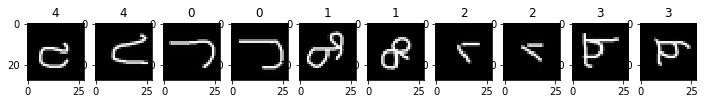

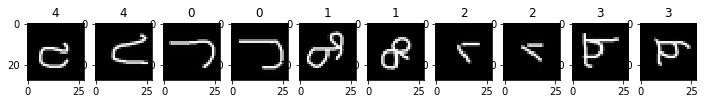

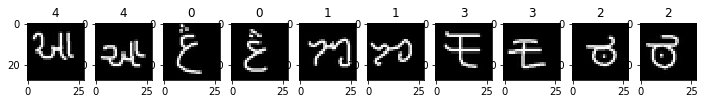

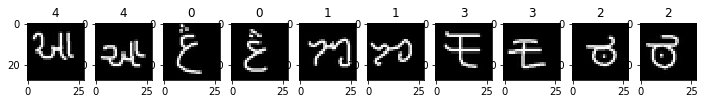

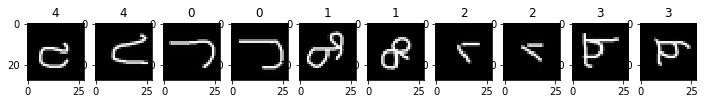

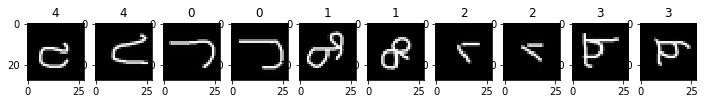

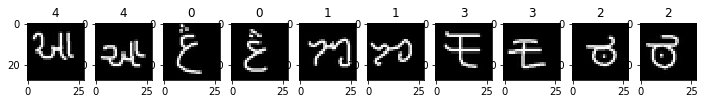

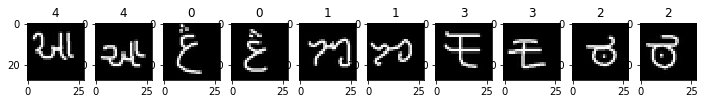

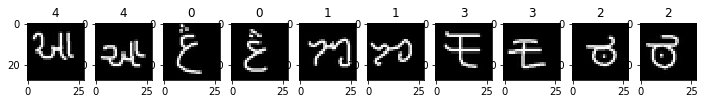

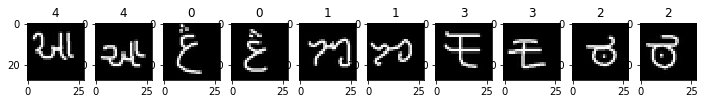

In [ ]:
for _ in range(0,10):
  plot(tasksets.train.sample(),20)


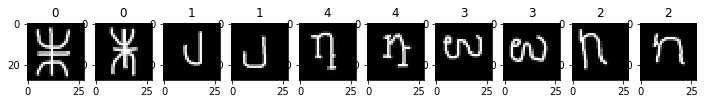

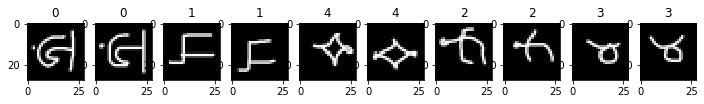

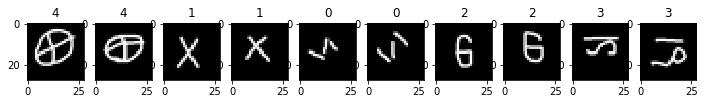

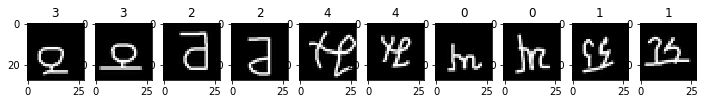

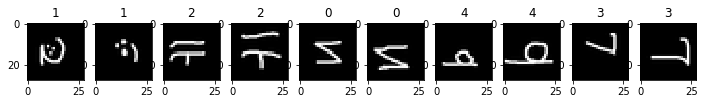

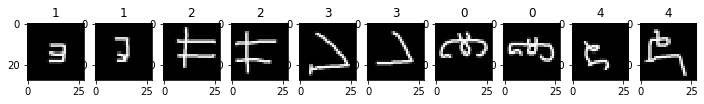

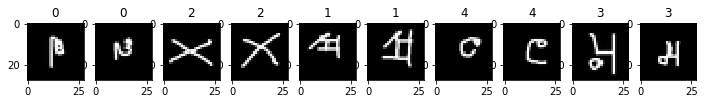

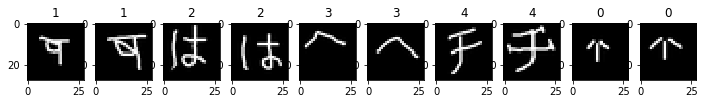

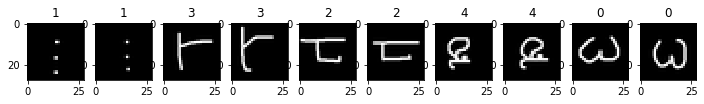

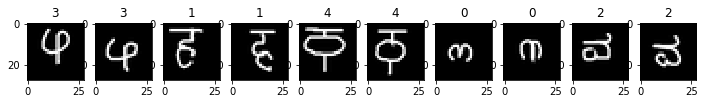

In [ ]:
for _ in range(0,10):
  plot(tasksets.test.sample(),20)
